In [529]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
from sklearn.metrics import confusion_matrix
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

In [530]:
# Creating a list of Zillow fie names for import and ensuring that all files can be read in properly
list_of_file_names = glob.glob("./zip_2/*.csv")

read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
list_of_file_names_org = list_of_file_names
# Removing files that do not load properly
for x in fail_list:
    del list_of_file_names[x]

In [531]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [532]:
# Running the above function and making sure that our files contain enough zipcodes to give us sufficient data to merge

useful_df = build_useful_df(read_data_list_2)
sixteen_list = []
good_columns = []
sixteen_good = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)
# Making sure that our files contain up to date information
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)
# Selecting our list of files to use by cross referencing the lists that define files with attributes that we are looking for
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [533]:
# Selecting our target data (price per square foot)
target_data = useful_df[23]
# Extracting the files themselves from the glob
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [534]:
# Docs that don't need feature engineering. They are already aggregates. These may be used for future feature engineering
pure_features = [0, 71, 75, 77, 79, 81]
#useful_df[0].head(50)

In [535]:
# Creating a function that builds the features for the model
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    return features
    
# Creating the time frame we want to utilize for our prediction as well as generting the features and checking the data
# to be certain that it fits the timeframe we are looking for
def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    

    
    return df_one, target



# Generate the initial modeling data
test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)






# Specifying different timeframes that we will use to generate data from the past and appending it to our training dataset
date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

#### w2v features

In [536]:
# Importing w2v features
w2v_features = pd.read_csv('real_business_w2v_features_3_6')
# Making sure that the type is compatible with other files
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)
# Using the zip code as an index
w2v_features.index = w2v_features['postal_code']
# Removing unnecessary columns
w2v_features = w2v_features.iloc[:, 1:]

#### Business features

In [537]:
# Importing business data features
business_features = pd.read_csv('real_business_features_3_4')
# Making sure that the type is compatible with other files
business_features['postal_code'] = business_features['postal_code'].astype(str)
# Using the zip code as an index
business_features = business_features.set_index('postal_code')

#### Adjusting train test sets

In [538]:
# Resetting the index for the Zillow features
train_features = train_features.reset_index()
test_features = test_features.reset_index()
train_targets = train_targets.reset_index()
test_targets = test_targets.reset_index()

In [539]:
# Merging on index for train and test features and targets so it doesn't multiply rows as well as resetting the index to zips
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')
train_merge = train_merge.set_index('RegionName_x')
test_merge = test_merge.set_index('RegionName_x')

In [540]:
# Merging on index for business train and test features and targets so it doesn't multiply rows
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [541]:
# Merging on index for w2v train and test features and targets so it doesn't multiply rows
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [542]:
# Making sure that all zipcodes are shared in the different feature sets and dropping NA values
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')
test_merge = new_zillow_test_merge.iloc[:, :-10]
new_zillow_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')
train_merge = new_zillow_train_merge.iloc[:, :-10]
train_merge = train_merge.drop('RegionName_y', 1)
test_merge = test_merge.drop('RegionName_y', 1)
train_merge.dropna(inplace=True)
test_merge.dropna(inplace=True)
business_train_merge.dropna(inplace=True)
business_test_merge.dropna(inplace=True)
w2v_train_merge.dropna(inplace=True)
w2v_test_merge.dropna(inplace=True)
test_merge.to_csv('test_set_final.csv')

#### Creating arrays and train test splits

In [543]:
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

#### Normalizing the arrays

In [544]:
# Creating a function that normalizes the arrays
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [545]:
# Normalizing the arrays
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)
y_test.var()

0.0028560998107322942

In [546]:
# Checking the variance in training set and test set
print('train mean')
print(y_train.mean())
print('train min')
print(y_train.min())
print('train max')
print(y_train.max())
print('test mean')
print(y_test.mean())
print('test min')
print(y_test.min())
print('test max')
print( y_test.max())

train mean
1.03568676443
train min
0.809566962437
train max
1.32300764356
test mean
1.01812630226
test min
0.833675690212
test max
1.18704258259


#### Creating classes for targets

In [547]:
# Defining a function to generate classes for categorical model
def create_y_class_2(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    
    for y in y_list:
        if y <= .9:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .9 and y <= .97:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .97 and y < 1.03:
            y_3.append(1)
        else:
            y_3.append(0)
        if y >= 1.03 and y < 1.1:
            y_4.append(1)
        else:
            y_4.append(0)
        if y >= 1.1:
            y_5.append(1)
        else:
            y_5.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    return y_df

In [548]:
# Creating classes for categorical model
y_cat_train = create_y_class_2(y_train)
y_cat_test = create_y_class_2(y_test)
y_cat_train_w2v = create_y_class_2(y_train_w2v)
y_cat_test_w2v = create_y_class_2(y_test_w2v)
y_cat_train_business = create_y_class_2(y_train_business)
y_cat_test_business = create_y_class_2(y_test_business)
y_test_business.var()

0.0028560998107322942

#### Regression Models

In [509]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [510]:
model.fit(x=X_train, y=y_train, 
          batch_size=2000, 
          epochs=200, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/200
2839/2839 [==============================] - 29s 10ms/step - loss: 18.7427 - val_loss: 0.3602
Epoch 2/200
2839/2839 [==============================] - 0s 37us/step - loss: 0.3542 - val_loss: 0.1392
Epoch 3/200
2839/2839 [==============================] - 0s 35us/step - loss: 0.2824 - val_loss: 0.1391
Epoch 4/200
2839/2839 [==============================] - 0s 31us/step - loss: 0.2419 - val_loss: 0.0930
Epoch 5/200
2839/2839 [==============================] - 0s 32us/step - loss: 0.2136 - val_loss: 0.0818
Epoch 6/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.2065 - val_loss: 0.0596
Epoch 7/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.1926 - val_loss: 0.0398
Epoch 8/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.1765 - val_loss: 0.0476
Epoch 9/200
2839/2839 [==============================] - 0s 32us/step - loss: 0.1768 - val_loss: 0.0522
Epoch 10/200
28

2839/2839 [==============================] - 0s 31us/step - loss: 0.0295 - val_loss: 0.0133
Epoch 79/200
2839/2839 [==============================] - 0s 35us/step - loss: 0.0327 - val_loss: 0.0115
Epoch 80/200
2839/2839 [==============================] - 0s 32us/step - loss: 0.0288 - val_loss: 0.0044
Epoch 81/200
2839/2839 [==============================] - 0s 32us/step - loss: 0.0247 - val_loss: 0.0036
Epoch 82/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.0242 - val_loss: 0.0038
Epoch 83/200
2839/2839 [==============================] - 0s 32us/step - loss: 0.0235 - val_loss: 0.0029
Epoch 84/200
2839/2839 [==============================] - 0s 34us/step - loss: 0.0232 - val_loss: 0.0030
Epoch 85/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.0235 - val_loss: 0.0032
Epoch 86/200
2839/2839 [==============================] - 0s 33us/step - loss: 0.0219 - val_loss: 0.0029
Epoch 87/200
2839/2839 [==============================] - 0s 32us/st

2839/2839 [==============================] - 0s 43us/step - loss: 0.0068 - val_loss: 0.0029
Epoch 156/200
2839/2839 [==============================] - 0s 42us/step - loss: 0.0064 - val_loss: 0.0028
Epoch 157/200
2839/2839 [==============================] - 0s 38us/step - loss: 0.0060 - val_loss: 0.0030
Epoch 158/200
2839/2839 [==============================] - 0s 41us/step - loss: 0.0059 - val_loss: 0.0029
Epoch 159/200
2839/2839 [==============================] - 0s 37us/step - loss: 0.0061 - val_loss: 0.0031
Epoch 160/200
2839/2839 [==============================] - 0s 43us/step - loss: 0.0058 - val_loss: 0.0029
Epoch 161/200
2839/2839 [==============================] - 0s 43us/step - loss: 0.0057 - val_loss: 0.0034
Epoch 162/200
2839/2839 [==============================] - 0s 44us/step - loss: 0.0053 - val_loss: 0.0040
Epoch 163/200
2839/2839 [==============================] - 0s 40us/step - loss: 0.0050 - val_loss: 0.0035
Epoch 164/200
2839/2839 [==============================] - 0

In [740]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [743]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 0.0043
Epoch 2/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0055 - val_loss: 0.0088
Epoch 3/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0137 - val_loss: 0.0133
Epoch 4/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0160 - val_loss: 0.0030
Epoch 5/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0033 - val_loss: 0.0029
Epoch 6/500
2839/2839 [==============================] - 0s 41us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/500
2839/2839 [==============================] - 0s 34us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 9/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/500
2839

2839/2839 [==============================] - 0s 29us/step - loss: 0.1538 - val_loss: 0.2634
Epoch 156/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.2671 - val_loss: 0.2698
Epoch 157/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.2900 - val_loss: 0.8574
Epoch 158/500
2839/2839 [==============================] - 0s 32us/step - loss: 4.1008 - val_loss: 30.9265
Epoch 159/500
2839/2839 [==============================] - 0s 30us/step - loss: 37.3535 - val_loss: 24.0820
Epoch 160/500
2839/2839 [==============================] - 0s 30us/step - loss: 18.2658 - val_loss: 0.0029
Epoch 161/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0098 - val_loss: 0.0029
Epoch 162/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0082 - val_loss: 0.0029
Epoch 163/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0070 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================]

2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 310/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 311/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0033
Epoch 312/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 313/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 314/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 315/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 316/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 317/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 0.0039
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 35us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 464/500
2839/2839 [==============================] - 0s 49us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 465/500
2839/2839 [==============================] - 0s 32us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 466/500
2839/2839 [==============================] - 0s 39us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 467/500
2839/2839 [==============================] - 0s 33us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 468/500
2839/2839 [==============================] - 0s 28us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 469/500
2839/2839 [==============================] - 0s 31us/step - loss: 0.0034 - val_loss: 0.0030
Epoch 470/500
2839/2839 [==============================] - 0s 29us/step - loss: 0.0039 - val_loss: 0.0047
Epoch 471/500
2839/2839 [==============================] - 0s 30us/step - loss: 0.0074 - val_loss: 0.0031
Epoch 472/500
2839/2839 [==============================] - 0

In [745]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [746]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

Train on 2839 samples, validate on 331 samples
Epoch 1/500
2839/2839 [==============================] - 4s 1ms/step - loss: 3.1253 - val_loss: 0.3215
Epoch 2/500
2839/2839 [==============================] - 0s 60us/step - loss: 0.3927 - val_loss: 0.2637
Epoch 3/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.3240 - val_loss: 0.2399
Epoch 4/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2909 - val_loss: 0.1291
Epoch 5/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2447 - val_loss: 0.1072
Epoch 6/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.2297 - val_loss: 0.1186
Epoch 7/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.2025 - val_loss: 0.2005
Epoch 8/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.2366 - val_loss: 0.2338
Epoch 9/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.2277 - val_loss: 0.1693
Epoch 10/500
2839/

2839/2839 [==============================] - 0s 74us/step - loss: 0.0199 - val_loss: 0.0030
Epoch 156/500
2839/2839 [==============================] - 0s 67us/step - loss: 0.0184 - val_loss: 0.0029
Epoch 157/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0193 - val_loss: 0.0029
Epoch 158/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0183 - val_loss: 0.0029
Epoch 159/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0184 - val_loss: 0.0027
Epoch 160/500
2839/2839 [==============================] - 0s 64us/step - loss: 0.0198 - val_loss: 0.0031
Epoch 161/500
2839/2839 [==============================] - 0s 66us/step - loss: 0.0197 - val_loss: 0.0031
Epoch 162/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0185 - val_loss: 0.0030
Epoch 163/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0189 - val_loss: 0.0029
Epoch 164/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 78us/step - loss: 0.0067 - val_loss: 0.0026
Epoch 310/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0028
Epoch 311/500
2839/2839 [==============================] - 0s 79us/step - loss: 0.0067 - val_loss: 0.0027
Epoch 312/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0069 - val_loss: 0.0025
Epoch 313/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0063 - val_loss: 0.0027
Epoch 314/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0068 - val_loss: 0.0028
Epoch 315/500
2839/2839 [==============================] - 0s 75us/step - loss: 0.0067 - val_loss: 0.0025
Epoch 316/500
2839/2839 [==============================] - 0s 72us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 317/500
2839/2839 [==============================] - 0s 77us/step - loss: 0.0063 - val_loss: 0.0031
Epoch 318/500
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 73us/step - loss: 0.0031 - val_loss: 0.0028
Epoch 464/500
2839/2839 [==============================] - 0s 63us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 465/500
2839/2839 [==============================] - 0s 73us/step - loss: 0.0027 - val_loss: 0.0024
Epoch 466/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0028 - val_loss: 0.0024
Epoch 467/500
2839/2839 [==============================] - 0s 74us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 468/500
2839/2839 [==============================] - 0s 62us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 469/500
2839/2839 [==============================] - 0s 78us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 470/500
2839/2839 [==============================] - 0s 83us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 471/500
2839/2839 [==============================] - 0s 65us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 472/500
2839/2839 [==============================] - 0

#### Switching to categorical model and generating metrics to analyze performance


In [549]:
# Generating metrics for categorical model
def model_metrics(predictions, y_test, x_train):
    df = pd.DataFrame(predictions) 
    zips = x_train.index
    df['zips'] = zips
    predicted_classes = predictions.argmax(axis=1)
    # predicting a loss 3% or larger by seeing if max loss probability is higher then slight gain
    df['loss'] = np.where(df[0] > df[3], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then slight loss
    df['gain'] = np.where(df[4] > df[1], 1, 0)
    df = pd.merge(df, y_test, left_index=True, right_index=True, how='inner')
    # predicting a loss 3% or larger by seeing if max loss probability is higher then mean probibility 
    df['loss_large'] = np.where(df[0] > df[2], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then mean probibility 
    df['gain_large'] = np.where(df[4] > df[2], 1, 0)
    # Cheching if loss is predicted and a loss of 3% or more occurs
    df['loss_true_true'] = np.where((df['loss'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Checking if loss is predicted and price stays at the mean
    df['loss_stay'] = np.where((df['loss'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large loss is predicted and a loss of 3% or more occurs
    df['loss_large_true'] = np.where((df['loss_large'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Cheching if large loss is predicted and price stays at the mean
    df['loss_large_stay'] = np.where((df['loss_large'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if gain is predicted and a loss of 3% or more occurs
    df['gain_true_true'] = np.where((df['gain'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Checking if gain is predicted and price stays at the mean
    df['gain_stay'] = np.where((df['gain'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large gain is predicted and a gain of 3% or more occurs
    df['gain_large_true'] = np.where((df['gain_large'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Cheching if large gain is predicted and price stays at the mean
    df['gain_large_stay'] = np.where((df['gain_large'] == 1) & (df['3'] == 1), 1, 0)
    #df['gain_large_large'] = np.where((df['gain_large'] == 1) & (df['5'] == 1), 1, 0)
    # Checking if both loss and gain are selected. This appears to mean high volitility
    df['volitile'] = np.where((df['loss'] == 1) & (df['gain'] == 1), 1, 0)
    df['top_vs_mean_low'] = (df[4] + df[3]) - (df[2] + df[1])
    #df['zips'] = df.index
    df = df.sort_values('top_vs_mean_low', ascending=False)
    top_10 = []
    # Here I switched 10% to 15% to generate a better comparison. In production this may revert to 10%
    top = round(len(df) * .15)
    for num in range(top):
        top_10.append(1)
    finish_list = len(df) - len(top_10)
    for num in range(finish_list):
        top_10.append(0)
    df['top_vs_mean_low_select'] = top_10
    df['top_vs_mean_low_select_true'] = np.where((df['top_vs_mean_low_select'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['top_vs_mean_low_select_large'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['5'] == 1), 1, 0)
    df['gain_large_true_large'] = np.where((df['gain'] == 1) & (df['5'] == 1), 1, 0)
    df['top_vs_mean_low_select_mean'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['3'] == 1), 1, 0)
    df['predicted_classes'] = predicted_classes
    df['predicted_classes_gain'] = np.where((df['predicted_classes'] == 3) | (df['predicted_classes'] == 4) , 1, 0)
    df['predicted_classes_gain_true'] = np.where((df['predicted_classes_gain'] == 1)  & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['predicted_classes_gain_large_true'] = np.where((df['predicted_classes_gain'] == 1) & (df['5'] == 1), 1, 0)
    df['predicted_classes_gain_mean'] = np.where((df['predicted_classes_gain'] == 1) & (df['3'] == 1), 1, 0)
    df['gain_true'] = np.where((df['4'] == 1) | (df['5'] == 1), 1, 0)
    df = df.set_index('zips')
    
    gain_pred = df['gain'].sum()
    gain_large_pred = df['gain_large'].sum()
    
    gain_stay_true = (df['gain_true_true'].sum() + df['gain_stay'].sum()) / df['gain'].sum()
    
    # Since we are focused on gain at the moment the loss predictions are commited out. This may change in production
    gain_true = df['gain_true_true'].sum() / df['gain'].sum()
    #loss_stay_true = (df['loss_true_true'].sum() + df['loss_stay'].sum()) / df['loss'].sum()
    #loss_stay_true = df['loss_true_true'].sum() / df['loss'].sum()
    gain_stay_large_true = (df['gain_large_true'].sum() + df['gain_large_stay'].sum()) / df['gain_large'].sum()
    gain_large_true = df['gain_large_true'].sum() / df['gain_large'].sum()
    #loss_stay_large_true = (df['loss_large_true'].sum() + df['loss_large_stay']) / df['loss_large'].sum()
    #loss_large_true = df['loss_large_true'].sum() / df['loss_large'].sum()
    volitile = df['volitile'].sum()
    four_five_split = df['top_vs_mean_low_select_true'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_large = df['top_vs_mean_low_select_large'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_mean = (df['top_vs_mean_low_select_true'].sum() + df['top_vs_mean_low_select_mean'].sum()) / df['top_vs_mean_low_select'].sum()
    predicted_classes_gain_true = df['predicted_classes_gain_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_large_true = df['predicted_classes_gain_large_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_mean = (df['predicted_classes_gain_true'].sum() + df['predicted_classes_gain_mean'].sum()) / df['predicted_classes_gain'].sum()
    gain_true_large = df['gain_large_true_large'].sum() / df['gain'].sum()
    return gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df 

#### Adding weights to classes

In [550]:
class_weight = {0 : 2,
    1: 1,
    2: .5,
    3: 1,
    4: 2}

In [552]:
df_zillow_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001))
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(120,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    zillow_model_2 = model.fit(x=X_train, y=y_cat_train, 
          batch_size=2000, 
          epochs=175, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test)
    loss = zillow_model_2.history['val_loss'][-1]
    acc = zillow_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_z = model_metrics(predictions, y_cat_test, test_merge)
    df_zillow_analysis.loc[num,'pred_count'] = gain_pred
    df_zillow_analysis.loc[num,'gain_10%'] = gain_true_large
    df_zillow_analysis.loc[num,'gain_3%'] = gain_true
    df_zillow_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_zillow_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_zillow_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_zillow_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_zillow_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_zillow_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_zillow_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_zillow_analysis.loc[num,'loss'] = loss
    df_zillow_analysis.loc[num,'acc'] = acc
    print(num)
df_175_w_z = df_zillow_analysis
df_zillow_analysis

Train on 2839 samples, validate on 331 samples
Epoch 1/175
2839/2839 [==============================] - 16s 6ms/step - loss: 1.8391 - acc: 0.3047 - val_loss: 1.8220 - val_acc: 0.3384
Epoch 2/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.6948 - acc: 0.3653 - val_loss: 1.7596 - val_acc: 0.3293
Epoch 3/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6571 - acc: 0.3776 - val_loss: 1.7454 - val_acc: 0.3293
Epoch 4/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.6190 - acc: 0.3861 - val_loss: 1.7388 - val_acc: 0.3293
Epoch 5/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.6153 - acc: 0.3949 - val_loss: 1.6858 - val_acc: 0.3384
Epoch 6/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.5957 - acc: 0.3956 - val_loss: 1.6906 - val_acc: 0.3384
Epoch 7/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.5741 - acc: 0.3853 - val_loss: 1.7024 - val_acc: 0.3293
E

2839/2839 [==============================] - 0s 44us/step - loss: 1.2776 - acc: 0.4797 - val_loss: 1.4692 - val_acc: 0.4139
Epoch 61/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2607 - acc: 0.4780 - val_loss: 1.5212 - val_acc: 0.4230
Epoch 62/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2572 - acc: 0.4713 - val_loss: 1.6011 - val_acc: 0.3837
Epoch 63/175
2839/2839 [==============================] - 0s 30us/step - loss: 1.2942 - acc: 0.4463 - val_loss: 1.5939 - val_acc: 0.3776
Epoch 64/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2600 - acc: 0.4646 - val_loss: 1.5001 - val_acc: 0.4139
Epoch 65/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2273 - acc: 0.4727 - val_loss: 1.4443 - val_acc: 0.4290
Epoch 66/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2441 - acc: 0.4748 - val_loss: 1.4229 - val_acc: 0.4592
Epoch 67/175
2839/2839 [==============================

Epoch 120/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.1050 - acc: 0.5129 - val_loss: 1.3896 - val_acc: 0.4773
Epoch 121/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1061 - acc: 0.5319 - val_loss: 1.3848 - val_acc: 0.4743
Epoch 122/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1001 - acc: 0.5375 - val_loss: 1.3244 - val_acc: 0.5136
Epoch 123/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.1233 - acc: 0.5312 - val_loss: 1.3224 - val_acc: 0.5257
Epoch 124/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1013 - acc: 0.5350 - val_loss: 1.3468 - val_acc: 0.5196
Epoch 125/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.0980 - acc: 0.5400 - val_loss: 1.3197 - val_acc: 0.5227
Epoch 126/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.1020 - acc: 0.5358 - val_loss: 1.3026 - val_acc: 0.5529
Epoch 127/175
2839/2839 [=========

2839/2839 [==============================] - 0s 38us/step - loss: 1.6301 - acc: 0.3776 - val_loss: 1.7688 - val_acc: 0.3293
Epoch 5/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.6102 - acc: 0.3769 - val_loss: 1.7828 - val_acc: 0.3293
Epoch 6/175
2839/2839 [==============================] - 0s 30us/step - loss: 1.5861 - acc: 0.3829 - val_loss: 1.7287 - val_acc: 0.3293
Epoch 7/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.5755 - acc: 0.3956 - val_loss: 1.8074 - val_acc: 0.3293
Epoch 8/175
2839/2839 [==============================] - 0s 39us/step - loss: 1.5768 - acc: 0.3871 - val_loss: 1.7845 - val_acc: 0.3323
Epoch 9/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.5689 - acc: 0.3846 - val_loss: 1.6975 - val_acc: 0.3535
Epoch 10/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.5473 - acc: 0.4019 - val_loss: 1.7203 - val_acc: 0.3353
Epoch 11/175
2839/2839 [==============================] - 0

Epoch 64/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.2473 - acc: 0.4752 - val_loss: 1.4801 - val_acc: 0.4683
Epoch 65/175
2839/2839 [==============================] - 0s 37us/step - loss: 1.2342 - acc: 0.4783 - val_loss: 1.4478 - val_acc: 0.4924
Epoch 66/175
2839/2839 [==============================] - 0s 37us/step - loss: 1.2416 - acc: 0.4886 - val_loss: 1.5684 - val_acc: 0.4411
Epoch 67/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2696 - acc: 0.4558 - val_loss: 1.4997 - val_acc: 0.4562
Epoch 68/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2373 - acc: 0.4776 - val_loss: 1.4721 - val_acc: 0.4773
Epoch 69/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2368 - acc: 0.4801 - val_loss: 1.5283 - val_acc: 0.4320
Epoch 70/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2294 - acc: 0.4847 - val_loss: 1.4639 - val_acc: 0.4683
Epoch 71/175
2839/2839 [=================

2839/2839 [==============================] - 0s 36us/step - loss: 1.1388 - acc: 0.5470 - val_loss: 1.2774 - val_acc: 0.5680
Epoch 124/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.0985 - acc: 0.5424 - val_loss: 1.2956 - val_acc: 0.5498
Epoch 125/175
2839/2839 [==============================] - 0s 39us/step - loss: 1.1069 - acc: 0.5255 - val_loss: 1.3098 - val_acc: 0.5227
Epoch 126/175
2839/2839 [==============================] - 0s 41us/step - loss: 1.0831 - acc: 0.5594 - val_loss: 1.3705 - val_acc: 0.4864
Epoch 127/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.1018 - acc: 0.5365 - val_loss: 1.5104 - val_acc: 0.4109
Epoch 128/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.1695 - acc: 0.4815 - val_loss: 1.3850 - val_acc: 0.4743
Epoch 129/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.0982 - acc: 0.5298 - val_loss: 1.3344 - val_acc: 0.5619
Epoch 130/175
2839/2839 [=======================

2839/2839 [==============================] - 0s 34us/step - loss: 1.5966 - acc: 0.3956 - val_loss: 1.7411 - val_acc: 0.3202
Epoch 8/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5759 - acc: 0.3875 - val_loss: 1.7252 - val_acc: 0.3233
Epoch 9/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5861 - acc: 0.3811 - val_loss: 1.7166 - val_acc: 0.3233
Epoch 10/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5552 - acc: 0.3924 - val_loss: 1.7008 - val_acc: 0.3323
Epoch 11/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5475 - acc: 0.4178 - val_loss: 1.7530 - val_acc: 0.3172
Epoch 12/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.5394 - acc: 0.3959 - val_loss: 1.7414 - val_acc: 0.3172
Epoch 13/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5204 - acc: 0.4058 - val_loss: 1.7196 - val_acc: 0.3202
Epoch 14/175
2839/2839 [==============================] 

Epoch 67/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2129 - acc: 0.5041 - val_loss: 1.5567 - val_acc: 0.4109
Epoch 68/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2562 - acc: 0.4738 - val_loss: 1.5941 - val_acc: 0.3807
Epoch 69/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2433 - acc: 0.4653 - val_loss: 1.4657 - val_acc: 0.4411
Epoch 70/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2092 - acc: 0.4822 - val_loss: 1.4032 - val_acc: 0.4502
Epoch 71/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2343 - acc: 0.4829 - val_loss: 1.3383 - val_acc: 0.5076
Epoch 72/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2158 - acc: 0.5058 - val_loss: 1.3691 - val_acc: 0.4955
Epoch 73/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.2050 - acc: 0.5129 - val_loss: 1.3789 - val_acc: 0.4864
Epoch 74/175
2839/2839 [=================

2839/2839 [==============================] - 0s 34us/step - loss: 1.1034 - acc: 0.5150 - val_loss: 1.4406 - val_acc: 0.4773
Epoch 127/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.0968 - acc: 0.5203 - val_loss: 1.5039 - val_acc: 0.4773
Epoch 128/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1230 - acc: 0.5037 - val_loss: 1.4000 - val_acc: 0.5378
Epoch 129/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.0947 - acc: 0.5273 - val_loss: 1.4727 - val_acc: 0.4804
Epoch 130/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.1082 - acc: 0.5213 - val_loss: 1.3983 - val_acc: 0.5136
Epoch 131/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.0846 - acc: 0.5386 - val_loss: 1.3828 - val_acc: 0.5287
Epoch 132/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.0753 - acc: 0.5467 - val_loss: 1.3943 - val_acc: 0.5106
Epoch 133/175
2839/2839 [=======================

2839/2839 [==============================] - 0s 34us/step - loss: 1.5613 - acc: 0.4033 - val_loss: 1.6957 - val_acc: 0.3414
Epoch 11/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5495 - acc: 0.4153 - val_loss: 1.7542 - val_acc: 0.3263
Epoch 12/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.5305 - acc: 0.4118 - val_loss: 1.6658 - val_acc: 0.3535
Epoch 13/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5194 - acc: 0.4287 - val_loss: 1.7110 - val_acc: 0.3414
Epoch 14/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.5127 - acc: 0.4216 - val_loss: 1.7192 - val_acc: 0.3353
Epoch 15/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5214 - acc: 0.4054 - val_loss: 1.7418 - val_acc: 0.3353
Epoch 16/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5078 - acc: 0.4075 - val_loss: 1.6791 - val_acc: 0.3384
Epoch 17/175
2839/2839 [==============================

Epoch 70/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2411 - acc: 0.4787 - val_loss: 1.3352 - val_acc: 0.5196
Epoch 71/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2437 - acc: 0.4981 - val_loss: 1.3214 - val_acc: 0.5227
Epoch 72/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2419 - acc: 0.5012 - val_loss: 1.4363 - val_acc: 0.4502
Epoch 73/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2176 - acc: 0.4812 - val_loss: 1.4917 - val_acc: 0.4381
Epoch 74/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2407 - acc: 0.4695 - val_loss: 1.5229 - val_acc: 0.4230
Epoch 75/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2351 - acc: 0.4650 - val_loss: 1.4832 - val_acc: 0.4471
Epoch 76/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2090 - acc: 0.4868 - val_loss: 1.4322 - val_acc: 0.4804
Epoch 77/175
2839/2839 [=================

2839/2839 [==============================] - 0s 33us/step - loss: 1.1130 - acc: 0.5354 - val_loss: 1.3379 - val_acc: 0.5650
Epoch 130/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1046 - acc: 0.5358 - val_loss: 1.3158 - val_acc: 0.5921
Epoch 131/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1016 - acc: 0.5417 - val_loss: 1.2713 - val_acc: 0.5650
Epoch 132/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1257 - acc: 0.5354 - val_loss: 1.2622 - val_acc: 0.5891
Epoch 133/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1017 - acc: 0.5382 - val_loss: 1.2760 - val_acc: 0.5650
Epoch 134/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.0960 - acc: 0.5460 - val_loss: 1.2707 - val_acc: 0.5619
Epoch 135/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1079 - acc: 0.5350 - val_loss: 1.2488 - val_acc: 0.5921
Epoch 136/175
2839/2839 [=======================

2839/2839 [==============================] - 0s 37us/step - loss: 1.5259 - acc: 0.3787 - val_loss: 1.6944 - val_acc: 0.3142
Epoch 14/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5213 - acc: 0.3885 - val_loss: 1.7113 - val_acc: 0.3142
Epoch 15/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5061 - acc: 0.3815 - val_loss: 1.7312 - val_acc: 0.3082
Epoch 16/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.4991 - acc: 0.3889 - val_loss: 1.7455 - val_acc: 0.3051
Epoch 17/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.4944 - acc: 0.3723 - val_loss: 1.6485 - val_acc: 0.3202
Epoch 18/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.4721 - acc: 0.4089 - val_loss: 1.6787 - val_acc: 0.3202
Epoch 19/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.4716 - acc: 0.3952 - val_loss: 1.6914 - val_acc: 0.3112
Epoch 20/175
2839/2839 [==============================

Epoch 72/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2326 - acc: 0.4361 - val_loss: 1.4726 - val_acc: 0.3837
Epoch 73/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2098 - acc: 0.4597 - val_loss: 1.4532 - val_acc: 0.4230
Epoch 74/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2192 - acc: 0.4512 - val_loss: 1.4394 - val_acc: 0.4260
Epoch 75/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2083 - acc: 0.4618 - val_loss: 1.3650 - val_acc: 0.4562
Epoch 76/175
2839/2839 [==============================] - 0s 50us/step - loss: 1.1982 - acc: 0.4688 - val_loss: 1.3555 - val_acc: 0.4532
Epoch 77/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2008 - acc: 0.4653 - val_loss: 1.3524 - val_acc: 0.4864
Epoch 78/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2280 - acc: 0.4660 - val_loss: 1.3231 - val_acc: 0.4955
Epoch 79/175
2839/2839 [=================

2839/2839 [==============================] - 0s 48us/step - loss: 1.0976 - acc: 0.4967 - val_loss: 1.4408 - val_acc: 0.4441
Epoch 132/175
2839/2839 [==============================] - 0s 46us/step - loss: 1.0910 - acc: 0.5012 - val_loss: 1.3639 - val_acc: 0.4773
Epoch 133/175
2839/2839 [==============================] - 0s 43us/step - loss: 1.0708 - acc: 0.5312 - val_loss: 1.3746 - val_acc: 0.4834
Epoch 134/175
2839/2839 [==============================] - 0s 41us/step - loss: 1.0565 - acc: 0.5343 - val_loss: 1.3642 - val_acc: 0.4743
Epoch 135/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.0985 - acc: 0.5143 - val_loss: 1.3812 - val_acc: 0.4683
Epoch 136/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.1039 - acc: 0.5118 - val_loss: 1.3491 - val_acc: 0.4804
Epoch 137/175
2839/2839 [==============================] - 0s 39us/step - loss: 1.0593 - acc: 0.5238 - val_loss: 1.4131 - val_acc: 0.4622
Epoch 138/175
2839/2839 [=======================

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,122.0,0.131148,0.704918,0.967213,0.20,0.80,0.94,0.063830,0.475177,0.865248,1.314027,0.534743
1,99.0,0.161616,0.787879,0.959596,0.22,0.82,0.96,0.109244,0.512605,0.873950,1.256399,0.574018
2,117.0,0.136752,0.709402,0.948718,0.24,0.76,0.92,0.112583,0.483444,0.867550,1.407440,0.459215
3,189.0,0.089947,0.587302,0.920635,0.26,0.80,0.94,0.071749,0.448430,0.856502,1.498032,0.438066
4,107.0,0.149533,0.757009,0.962617,0.22,0.80,0.94,0.078014,0.539007,0.907801,1.307601,0.516616


In [242]:
df_150_z_r

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,331.0,0.060423,0.392749,0.827795,0.14,0.70,0.96,0.060423,0.392749,0.827795,1.551617,0.332326
1,331.0,0.060423,0.392749,0.827795,0.14,0.64,0.96,0.060423,0.392749,0.827795,1.558010,0.332326
2,331.0,0.060423,0.392749,0.827795,0.14,0.74,0.96,0.060423,0.392749,0.827795,1.554780,0.332326
3,331.0,0.060423,0.392749,0.827795,0.16,0.68,0.98,0.060423,0.392749,0.827795,1.561087,0.332326
4,331.0,0.060423,0.392749,0.827795,0.16,0.66,0.94,0.060423,0.392749,0.827795,1.552505,0.332326


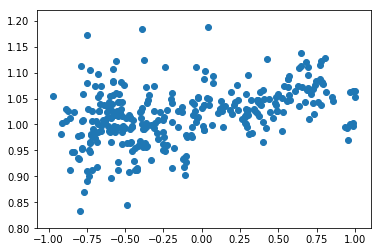

In [152]:
df_metrics['y_true'] = y_test
data_for_model = df_metrics[['top_vs_mean_low', 'y_true']]
plt.scatter(data_for_model['top_vs_mean_low'], data_for_model['y_true'])

In [ ]:
sns.stripplot()

In [251]:
df_175_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,128.0,0.125000,0.687500,0.960938,0.24,0.78,0.92,0.069620,0.487342,0.867089,1.297782,0.453172
1,139.0,0.115108,0.661871,0.942446,0.24,0.84,0.96,0.065868,0.491018,0.844311,1.274894,0.459215
2,121.0,0.132231,0.702479,0.950413,0.22,0.80,0.96,0.092199,0.510638,0.829787,1.159747,0.537764
3,119.0,0.134454,0.714286,0.941176,0.22,0.82,0.96,0.084967,0.483660,0.849673,1.210072,0.510574
4,98.0,0.163265,0.785714,0.959184,0.24,0.82,0.96,0.090909,0.530303,0.833333,1.197652,0.498489


In [553]:
df_175_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,122.0,0.131148,0.704918,0.967213,0.20,0.80,0.94,0.063830,0.475177,0.865248,1.314027,0.534743
1,99.0,0.161616,0.787879,0.959596,0.22,0.82,0.96,0.109244,0.512605,0.873950,1.256399,0.574018
2,117.0,0.136752,0.709402,0.948718,0.24,0.76,0.92,0.112583,0.483444,0.867550,1.407440,0.459215
3,189.0,0.089947,0.587302,0.920635,0.26,0.80,0.94,0.071749,0.448430,0.856502,1.498032,0.438066
4,107.0,0.149533,0.757009,0.962617,0.22,0.80,0.94,0.078014,0.539007,0.907801,1.307601,0.516616


In [554]:
df_400_z

NameError: name 'df_400_z' is not defined

In [1176]:
df_300_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,116.0,0.094972,0.724138,0.965517,0.272727,0.757576,0.909091,0.055556,0.472222,0.861111,1.484431,0.459215
1,72.0,0.094972,0.791667,0.958333,0.242424,0.757576,0.939394,0.120000,0.540000,0.910000,1.330855,0.534743
2,160.0,0.094972,0.631250,0.937500,0.303030,0.818182,0.939394,0.076142,0.482234,0.878173,1.462107,0.480363
3,109.0,0.094972,0.752294,0.963303,0.242424,0.757576,0.878788,0.070922,0.468085,0.872340,1.376176,0.531722
4,94.0,0.094972,0.755319,0.957447,0.242424,0.757576,0.939394,0.092199,0.475177,0.865248,1.363008,0.519637


In [1182]:
df_300_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,123.0,0.094972,0.707317,0.951220,0.272727,0.757576,0.878788,0.064935,0.461039,0.844156,1.434881,0.507553
1,97.0,0.094972,0.731959,0.969072,0.242424,0.787879,0.939394,0.090909,0.518182,0.909091,1.450340,0.459215
2,95.0,0.094972,0.789474,0.957895,0.242424,0.787879,0.939394,0.077778,0.488889,0.888889,1.533402,0.471299
3,89.0,0.094972,0.741573,0.943820,0.272727,0.787879,0.909091,0.083969,0.488550,0.870229,1.348234,0.513595
4,110.0,0.094972,0.709091,0.936364,0.242424,0.727273,0.909091,0.089655,0.496552,0.868966,1.400084,0.486405


In [1170]:
df_250_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,137.0,0.094972,0.671533,0.948905,0.272727,0.787879,0.939394,0.088435,0.537415,0.863946,1.421515,0.510574
1,94.0,0.094972,0.797872,0.957447,0.272727,0.757576,0.909091,0.090090,0.540541,0.846847,1.469787,0.468278
2,157.0,0.094972,0.636943,0.936306,0.303030,0.727273,0.878788,0.075676,0.470270,0.881081,1.468260,0.465257
3,115.0,0.094972,0.739130,0.956522,0.303030,0.757576,0.909091,0.101562,0.500000,0.859375,1.435143,0.480363
4,144.0,0.094972,0.659722,0.951389,0.272727,0.727273,0.909091,0.076471,0.494118,0.876471,1.542414,0.432024


In [1184]:
df_250_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,125.0,0.094972,0.704000,0.968000,0.272727,0.727273,0.909091,0.093960,0.463087,0.852349,1.548896,0.432024
1,88.0,0.094972,0.784091,0.965909,0.272727,0.757576,0.909091,0.115044,0.522124,0.858407,1.321403,0.489426
2,70.0,0.094972,0.757143,0.942857,0.242424,0.787879,0.939394,0.048780,0.495935,0.861789,1.274005,0.546828
3,92.0,0.094972,0.739130,0.934783,0.272727,0.757576,0.939394,0.112903,0.532258,0.830645,1.325635,0.489426
4,98.0,0.094972,0.775510,0.959184,0.242424,0.818182,0.939394,0.094488,0.535433,0.881890,1.214646,0.540785


In [1172]:
df_200_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,163.0,0.094972,0.625767,0.938650,0.303030,0.757576,0.909091,0.083770,0.465969,0.879581,1.407345,0.474320
1,144.0,0.094972,0.659722,0.951389,0.303030,0.787879,0.909091,0.092025,0.496933,0.883436,1.437591,0.483384
2,136.0,0.094972,0.669118,0.955882,0.303030,0.787879,0.969697,0.096970,0.515152,0.878788,1.464218,0.465257
3,133.0,0.094972,0.676692,0.954887,0.272727,0.787879,0.909091,0.095890,0.472603,0.842466,1.397490,0.480363
4,110.0,0.094972,0.754545,0.963636,0.272727,0.787879,0.939394,0.097561,0.495935,0.886179,1.270403,0.543807


In [1186]:
df_200_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,93.0,0.094972,0.795699,0.956989,0.272727,0.848485,0.969697,0.094828,0.439655,0.818966,1.196810,0.546828
1,103.0,0.094972,0.718447,0.932039,0.242424,0.757576,0.939394,0.097561,0.430894,0.829268,1.307886,0.483384
2,88.0,0.094972,0.784091,0.954545,0.242424,0.787879,0.939394,0.082569,0.495413,0.871560,1.204385,0.525680
3,82.0,0.094972,0.804878,0.951220,0.242424,0.787879,0.969697,0.078431,0.500000,0.803922,1.294213,0.492447
4,95.0,0.094972,0.768421,0.957895,0.242424,0.787879,0.939394,0.093525,0.525180,0.856115,1.235405,0.489426


In [1174]:
df_150_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.815789,0.960526,0.212121,0.787879,0.969697,0.107438,0.545455,0.884298,1.245467,0.580060
1,148.0,0.094972,0.668919,0.952703,0.272727,0.818182,0.939394,0.077778,0.461111,0.827778,1.352093,0.513595
2,180.0,0.094972,0.611111,0.916667,0.303030,0.727273,0.909091,0.070796,0.469027,0.858407,1.461635,0.407855
3,169.0,0.094972,0.633136,0.934911,0.272727,0.757576,0.909091,0.071429,0.464286,0.862245,1.357489,0.483384
4,170.0,0.094972,0.623529,0.947059,0.303030,0.787879,0.939394,0.096257,0.524064,0.887701,1.349806,0.474320


In [1188]:
df_150_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,106.0,0.094972,0.754717,0.952830,0.272727,0.787879,0.939394,0.081481,0.525926,0.851852,1.184601,0.483384
1,114.0,0.094972,0.745614,0.956140,0.303030,0.757576,0.878788,0.070312,0.507812,0.843750,1.175836,0.480363
2,152.0,0.094972,0.651316,0.953947,0.303030,0.757576,0.909091,0.084746,0.525424,0.847458,1.226775,0.474320
3,142.0,0.094972,0.676056,0.950704,0.333333,0.818182,0.939394,0.093750,0.506250,0.862500,1.246916,0.459215
4,113.0,0.094972,0.734513,0.938053,0.242424,0.787879,0.939394,0.110345,0.475862,0.882759,1.179244,0.513595


In [555]:
df_business_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(130,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    business_model_2 = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=175, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_business)
    loss = business_model_2.history['val_loss'][-1]
    acc = business_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_b = model_metrics(predictions, y_cat_test_business, business_test_merge)
    df_business_analysis.loc[num,'pred_count'] = gain_pred
    df_business_analysis.loc[num,'gain_10%'] = gain_true_large
    df_business_analysis.loc[num,'gain_3%'] = gain_true
    df_business_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_business_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_business_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_business_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_business_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_business_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_business_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_business_analysis.loc[num,'loss'] = loss
    df_business_analysis.loc[num,'acc'] = acc
    print(num)
df_175_w_b = df_business_analysis
df_business_analysis

Train on 2839 samples, validate on 331 samples
Epoch 1/175
2839/2839 [==============================] - 17s 6ms/step - loss: 2.2326 - acc: 0.1803 - val_loss: 1.8770 - val_acc: 0.2991
Epoch 2/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.7467 - acc: 0.3008 - val_loss: 1.8497 - val_acc: 0.3051
Epoch 3/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.7136 - acc: 0.3184 - val_loss: 1.8502 - val_acc: 0.2870
Epoch 4/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.6685 - acc: 0.3318 - val_loss: 1.7744 - val_acc: 0.3293
Epoch 5/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.6534 - acc: 0.3522 - val_loss: 1.7843 - val_acc: 0.3323
Epoch 6/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6437 - acc: 0.3625 - val_loss: 1.7868 - val_acc: 0.3323
Epoch 7/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.6290 - acc: 0.3586 - val_loss: 1.7319 - val_acc: 0.3323
E

2839/2839 [==============================] - 0s 35us/step - loss: 1.3111 - acc: 0.3945 - val_loss: 1.4309 - val_acc: 0.3142
Epoch 61/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2999 - acc: 0.4121 - val_loss: 1.4076 - val_acc: 0.3233
Epoch 62/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.3023 - acc: 0.4111 - val_loss: 1.4565 - val_acc: 0.3112
Epoch 63/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2771 - acc: 0.4047 - val_loss: 1.4169 - val_acc: 0.3112
Epoch 64/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2848 - acc: 0.4135 - val_loss: 1.4935 - val_acc: 0.2810
Epoch 65/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2845 - acc: 0.4012 - val_loss: 1.4152 - val_acc: 0.3172
Epoch 66/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.2876 - acc: 0.4104 - val_loss: 1.4148 - val_acc: 0.3142
Epoch 67/175
2839/2839 [==============================

Epoch 120/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1493 - acc: 0.4664 - val_loss: 1.3391 - val_acc: 0.4411
Epoch 121/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1526 - acc: 0.4731 - val_loss: 1.3129 - val_acc: 0.4713
Epoch 122/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1517 - acc: 0.4660 - val_loss: 1.3277 - val_acc: 0.4381
Epoch 123/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1422 - acc: 0.4653 - val_loss: 1.4179 - val_acc: 0.3927
Epoch 124/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1476 - acc: 0.4611 - val_loss: 1.3484 - val_acc: 0.4260
Epoch 125/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1438 - acc: 0.4611 - val_loss: 1.4265 - val_acc: 0.3686
Epoch 126/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1788 - acc: 0.4442 - val_loss: 1.3918 - val_acc: 0.4018
Epoch 127/175
2839/2839 [=========

2839/2839 [==============================] - 0s 37us/step - loss: 1.6926 - acc: 0.3417 - val_loss: 1.7946 - val_acc: 0.3323
Epoch 5/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6758 - acc: 0.3526 - val_loss: 1.8019 - val_acc: 0.3323
Epoch 6/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.6555 - acc: 0.3403 - val_loss: 1.7887 - val_acc: 0.3323
Epoch 7/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.6663 - acc: 0.3230 - val_loss: 1.7702 - val_acc: 0.3323
Epoch 8/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6368 - acc: 0.3473 - val_loss: 1.7280 - val_acc: 0.3293
Epoch 9/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.6248 - acc: 0.3656 - val_loss: 1.7508 - val_acc: 0.3263
Epoch 10/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.6074 - acc: 0.3533 - val_loss: 1.7069 - val_acc: 0.3293
Epoch 11/175
2839/2839 [==============================] - 0

2839/2839 [==============================] - 0s 34us/step - loss: 1.2735 - acc: 0.4325 - val_loss: 1.4254 - val_acc: 0.3656
Epoch 64/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2627 - acc: 0.4417 - val_loss: 1.4137 - val_acc: 0.3867
Epoch 65/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.2598 - acc: 0.4428 - val_loss: 1.3923 - val_acc: 0.4411
Epoch 66/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2850 - acc: 0.4322 - val_loss: 1.3680 - val_acc: 0.4290
Epoch 67/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2731 - acc: 0.4487 - val_loss: 1.3590 - val_acc: 0.4290
Epoch 68/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2759 - acc: 0.4325 - val_loss: 1.3939 - val_acc: 0.3927
Epoch 69/175
2839/2839 [==============================] - 0s 42us/step - loss: 1.2731 - acc: 0.4333 - val_loss: 1.4136 - val_acc: 0.3776
Epoch 70/175
2839/2839 [==============================

Epoch 123/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1558 - acc: 0.4544 - val_loss: 1.3736 - val_acc: 0.4441
Epoch 124/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1519 - acc: 0.4604 - val_loss: 1.3534 - val_acc: 0.4592
Epoch 125/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1506 - acc: 0.4748 - val_loss: 1.3821 - val_acc: 0.4260
Epoch 126/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.1453 - acc: 0.4600 - val_loss: 1.3699 - val_acc: 0.4411
Epoch 127/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.1259 - acc: 0.4695 - val_loss: 1.3427 - val_acc: 0.4592
Epoch 128/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1335 - acc: 0.4801 - val_loss: 1.3188 - val_acc: 0.4562
Epoch 129/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.1359 - acc: 0.4808 - val_loss: 1.3192 - val_acc: 0.4713
Epoch 130/175
2839/2839 [=========

2839/2839 [==============================] - 0s 34us/step - loss: 1.6475 - acc: 0.3396 - val_loss: 1.6979 - val_acc: 0.3323
Epoch 8/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.6482 - acc: 0.3512 - val_loss: 1.6771 - val_acc: 0.3323
Epoch 9/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6097 - acc: 0.3684 - val_loss: 1.6938 - val_acc: 0.3323
Epoch 10/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6017 - acc: 0.3568 - val_loss: 1.7082 - val_acc: 0.3293
Epoch 11/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.6045 - acc: 0.3477 - val_loss: 1.6614 - val_acc: 0.3323
Epoch 12/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.5754 - acc: 0.3698 - val_loss: 1.6738 - val_acc: 0.3323
Epoch 13/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5961 - acc: 0.3420 - val_loss: 1.7109 - val_acc: 0.3323
Epoch 14/175
2839/2839 [==============================] 

Epoch 67/175
2839/2839 [==============================] - 0s 42us/step - loss: 1.2774 - acc: 0.4259 - val_loss: 1.3914 - val_acc: 0.3474
Epoch 68/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2551 - acc: 0.4340 - val_loss: 1.3951 - val_acc: 0.3837
Epoch 69/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2598 - acc: 0.4340 - val_loss: 1.4074 - val_acc: 0.3988
Epoch 70/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2677 - acc: 0.4424 - val_loss: 1.3816 - val_acc: 0.4018
Epoch 71/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.2494 - acc: 0.4452 - val_loss: 1.4252 - val_acc: 0.3656
Epoch 72/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2441 - acc: 0.4273 - val_loss: 1.5105 - val_acc: 0.3112
Epoch 73/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.2648 - acc: 0.3991 - val_loss: 1.5098 - val_acc: 0.3142
Epoch 74/175
2839/2839 [=================

2839/2839 [==============================] - 0s 39us/step - loss: 1.1336 - acc: 0.4801 - val_loss: 1.3482 - val_acc: 0.4743
Epoch 127/175
2839/2839 [==============================] - 0s 39us/step - loss: 1.1629 - acc: 0.4533 - val_loss: 1.3921 - val_acc: 0.4532
Epoch 128/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.1677 - acc: 0.4466 - val_loss: 1.3438 - val_acc: 0.4804
Epoch 129/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.1424 - acc: 0.4727 - val_loss: 1.3198 - val_acc: 0.4955
Epoch 130/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.1485 - acc: 0.4762 - val_loss: 1.3163 - val_acc: 0.4955
Epoch 131/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.1396 - acc: 0.4819 - val_loss: 1.3097 - val_acc: 0.5015
Epoch 132/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.1150 - acc: 0.4731 - val_loss: 1.2938 - val_acc: 0.4894
Epoch 133/175
2839/2839 [=======================

2839/2839 [==============================] - 0s 38us/step - loss: 1.6144 - acc: 0.3322 - val_loss: 1.7122 - val_acc: 0.3323
Epoch 11/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5918 - acc: 0.3466 - val_loss: 1.7111 - val_acc: 0.3293
Epoch 12/175
2839/2839 [==============================] - 0s 31us/step - loss: 1.5713 - acc: 0.3635 - val_loss: 1.6861 - val_acc: 0.3323
Epoch 13/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5693 - acc: 0.3596 - val_loss: 1.6800 - val_acc: 0.3293
Epoch 14/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5791 - acc: 0.3568 - val_loss: 1.6759 - val_acc: 0.3293
Epoch 15/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5752 - acc: 0.3610 - val_loss: 1.6716 - val_acc: 0.3293
Epoch 16/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5627 - acc: 0.3653 - val_loss: 1.6629 - val_acc: 0.3263
Epoch 17/175
2839/2839 [==============================

2839/2839 [==============================] - 0s 35us/step - loss: 1.2443 - acc: 0.4537 - val_loss: 1.4800 - val_acc: 0.3807
Epoch 70/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2510 - acc: 0.4442 - val_loss: 1.4202 - val_acc: 0.4079
Epoch 71/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2339 - acc: 0.4618 - val_loss: 1.5101 - val_acc: 0.3474
Epoch 72/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2497 - acc: 0.4364 - val_loss: 1.4629 - val_acc: 0.3897
Epoch 73/175
2839/2839 [==============================] - 0s 32us/step - loss: 1.2350 - acc: 0.4642 - val_loss: 1.5460 - val_acc: 0.3444
Epoch 74/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.2533 - acc: 0.4283 - val_loss: 1.4750 - val_acc: 0.3807
Epoch 75/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.2315 - acc: 0.4445 - val_loss: 1.4312 - val_acc: 0.4079
Epoch 76/175
2839/2839 [==============================

2839/2839 [==============================] - 0s 38us/step - loss: 1.1212 - acc: 0.5012 - val_loss: 1.2627 - val_acc: 0.5166
Epoch 129/175
2839/2839 [==============================] - 0s 37us/step - loss: 1.1225 - acc: 0.4995 - val_loss: 1.3475 - val_acc: 0.4502
Epoch 130/175
2839/2839 [==============================] - 0s 39us/step - loss: 1.1492 - acc: 0.4833 - val_loss: 1.3854 - val_acc: 0.4290
Epoch 131/175
2839/2839 [==============================] - 0s 41us/step - loss: 1.1485 - acc: 0.4597 - val_loss: 1.3150 - val_acc: 0.4864
Epoch 132/175
2839/2839 [==============================] - 0s 41us/step - loss: 1.1158 - acc: 0.4931 - val_loss: 1.3096 - val_acc: 0.4834
Epoch 133/175
2839/2839 [==============================] - 0s 41us/step - loss: 1.1143 - acc: 0.5030 - val_loss: 1.3699 - val_acc: 0.4320
Epoch 134/175
2839/2839 [==============================] - 0s 46us/step - loss: 1.1397 - acc: 0.4716 - val_loss: 1.3812 - val_acc: 0.4320
Epoch 135/175
2839/2839 [=======================

2839/2839 [==============================] - 0s 42us/step - loss: 1.5849 - acc: 0.3505 - val_loss: 1.7413 - val_acc: 0.3323
Epoch 13/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.5604 - acc: 0.3667 - val_loss: 1.7469 - val_acc: 0.3293
Epoch 14/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.5636 - acc: 0.3427 - val_loss: 1.7201 - val_acc: 0.3323
Epoch 15/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.5491 - acc: 0.3656 - val_loss: 1.7264 - val_acc: 0.3293
Epoch 16/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.5587 - acc: 0.3639 - val_loss: 1.6988 - val_acc: 0.3323
Epoch 17/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.5436 - acc: 0.3642 - val_loss: 1.7009 - val_acc: 0.3323
Epoch 18/175
2839/2839 [==============================] - 0s 33us/step - loss: 1.5204 - acc: 0.3607 - val_loss: 1.7217 - val_acc: 0.3323
Epoch 19/175
2839/2839 [==============================

2839/2839 [==============================] - 0s 37us/step - loss: 1.2539 - acc: 0.4357 - val_loss: 1.4007 - val_acc: 0.4653
Epoch 72/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2545 - acc: 0.4385 - val_loss: 1.4639 - val_acc: 0.4199
Epoch 73/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.2560 - acc: 0.4333 - val_loss: 1.3880 - val_acc: 0.4622
Epoch 74/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2414 - acc: 0.4421 - val_loss: 1.3753 - val_acc: 0.4320
Epoch 75/175
2839/2839 [==============================] - 0s 40us/step - loss: 1.2398 - acc: 0.4498 - val_loss: 1.4218 - val_acc: 0.4169
Epoch 76/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.2303 - acc: 0.4403 - val_loss: 1.4523 - val_acc: 0.4018
Epoch 77/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.2430 - acc: 0.4234 - val_loss: 1.4474 - val_acc: 0.4079
Epoch 78/175
2839/2839 [==============================

2839/2839 [==============================] - 0s 33us/step - loss: 1.1129 - acc: 0.4959 - val_loss: 1.2966 - val_acc: 0.5287
Epoch 131/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.1291 - acc: 0.4868 - val_loss: 1.2690 - val_acc: 0.5468
Epoch 132/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.1565 - acc: 0.4945 - val_loss: 1.2602 - val_acc: 0.5529
Epoch 133/175
2839/2839 [==============================] - 0s 38us/step - loss: 1.1334 - acc: 0.4924 - val_loss: 1.2817 - val_acc: 0.5106
Epoch 134/175
2839/2839 [==============================] - 0s 36us/step - loss: 1.1152 - acc: 0.4871 - val_loss: 1.2982 - val_acc: 0.4985
Epoch 135/175
2839/2839 [==============================] - 0s 35us/step - loss: 1.1092 - acc: 0.4801 - val_loss: 1.2855 - val_acc: 0.5166
Epoch 136/175
2839/2839 [==============================] - 0s 34us/step - loss: 1.0920 - acc: 0.4981 - val_loss: 1.2499 - val_acc: 0.5680
Epoch 137/175
2839/2839 [=======================

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,150.0,0.106667,0.653333,0.933333,0.24,0.86,0.96,0.068063,0.497382,0.879581,1.253114,0.474320
1,103.0,0.135922,0.737864,0.970874,0.24,0.88,0.98,0.099174,0.570248,0.933884,1.237934,0.513595
2,121.0,0.115702,0.694215,0.933884,0.20,0.88,0.98,0.081481,0.548148,0.918519,1.376934,0.432024
3,124.0,0.112903,0.685484,0.935484,0.24,0.88,0.98,0.110294,0.536765,0.904412,1.312374,0.471299
4,124.0,0.120968,0.701613,0.959677,0.22,0.88,0.96,0.100000,0.528571,0.864286,1.300696,0.498489


In [493]:
df_metrics_b

,0,1,2,3,4,zips,loss,gain,1,2,...,top_vs_mean_low_select_true,top_vs_mean_low_select_large,gain_large_true_large,top_vs_mean_low_select_mean,predicted_classes,predicted_classes_gain,predicted_classes_gain_true,predicted_classes_gain_large_true,predicted_classes_gain_mean,gain_true
6,3.031247e-16,7.700027e-11,2.984889e-09,0.000034,0.999966,90210,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
117,6.455181e-07,1.668296e-04,1.397428e-03,0.052969,0.945467,85119,0,1,0,0,...,1,1,1,0,3,1,1,1,0,1
58,3.420597e-06,3.465159e-04,3.888561e-03,0.109646,0.886116,85387,0,1,0,0,...,1,0,0,0,3,1,1,0,0,1
200,2.868299e-04,5.019592e-03,3.028309e-03,0.030608,0.961057,44119,0,1,0,1,...,0,0,0,0,3,1,0,0,0,0
197,3.827243e-04,6.607884e-03,5.591956e-03,0.051575,0.935842,44123,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
238,4.407305e-04,8.681367e-03,1.378230e-02,0.119696,0.857400,28501,0,1,0,0,...,0,0,0,1,2,0,0,0,0,0
112,1.769189e-06,3.046874e-04,2.769239e-02,0.533417,0.438585,85201,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
91,4.122561e-06,9.443685e-04,3.141423e-02,0.491226,0.476412,85262,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
193,2.502714e-03,2.149867e-02,1.974948e-02,0.108461,0.847788,44128,0,1,0,0,...,1,1,1,0,1,0,0,0,0,1
220,5.928108e-04,9.287618e-03,3.917357e-02,0.267041,0.683905,44028,0,1,0,0,...,1,0,0,0,2,0,0,0,0,1


In [ ]:
df_400_w_b

In [1151]:
df_400_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,79.0,0.094972,0.810127,0.987342,0.272727,0.787879,0.969697,0.117117,0.549550,0.864865,1.373044,0.543807
1,53.0,0.094972,0.830189,0.981132,0.303030,0.848485,1.000000,0.098765,0.604938,0.888889,1.604796,0.477341
2,79.0,0.094972,0.848101,0.987342,0.212121,0.818182,1.000000,0.099099,0.558559,0.882883,1.497453,0.486405
3,108.0,0.094972,0.731481,0.953704,0.272727,0.848485,0.969697,0.100775,0.503876,0.883721,1.519598,0.441088
4,102.0,0.094972,0.754902,0.950980,0.303030,0.757576,0.939394,0.062500,0.506944,0.847222,1.441763,0.510574


In [1141]:
df_300_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.789474,0.973684,0.242424,0.848485,0.969697,0.142857,0.604396,0.879121,1.312308,0.486405
1,120.0,0.094972,0.700000,0.950000,0.272727,0.818182,0.939394,0.105960,0.543046,0.913907,1.336576,0.483384
2,88.0,0.094972,0.795455,0.977273,0.242424,0.848485,0.969697,0.094340,0.575472,0.924528,1.291740,0.498489
3,113.0,0.094972,0.707965,0.946903,0.242424,0.848485,0.969697,0.090226,0.541353,0.879699,1.287987,0.486405
4,100.0,0.094972,0.750000,0.960000,0.242424,0.848485,0.969697,0.100000,0.558333,0.916667,1.278520,0.507553


In [1153]:
df_300_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.699115,0.955752,0.242424,0.878788,0.969697,0.099291,0.560284,0.886525,1.383570,0.429003
1,70.0,0.094972,0.800000,0.971429,0.303030,0.878788,1.000000,0.101124,0.573034,0.898876,1.445286,0.477341
2,47.0,0.094972,0.851064,0.978723,0.242424,0.878788,1.000000,0.077922,0.571429,0.857143,1.424749,0.480363
3,54.0,0.094972,0.851852,0.981481,0.242424,0.878788,0.969697,0.123077,0.553846,0.907692,1.346164,0.429003
4,120.0,0.094972,0.700000,0.950000,0.333333,0.878788,0.969697,0.096774,0.522581,0.851613,1.408535,0.444109


In [1165]:
df_250_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.744681,0.957447,0.212121,0.818182,0.939394,0.089109,0.584158,0.900990,1.359825,0.435045
1,149.0,0.094972,0.644295,0.939597,0.272727,0.878788,0.969697,0.080000,0.520000,0.891429,1.311240,0.459215
2,79.0,0.094972,0.797468,0.974684,0.212121,0.878788,0.969697,0.111111,0.604938,0.950617,1.358138,0.447130
3,122.0,0.094972,0.704918,0.959016,0.242424,0.787879,0.939394,0.106667,0.533333,0.886667,1.275713,0.516616
4,87.0,0.094972,0.793103,0.965517,0.242424,0.818182,0.939394,0.092437,0.554622,0.890756,1.231637,0.522659


In [1163]:
df_250_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.740000,0.970000,0.242424,0.878788,0.969697,0.094017,0.564103,0.880342,1.310063,0.462236
1,82.0,0.094972,0.768293,0.975610,0.242424,0.818182,0.939394,0.097087,0.572816,0.902913,1.340102,0.465257
2,90.0,0.094972,0.800000,0.966667,0.272727,0.848485,0.939394,0.134615,0.605769,0.903846,1.218421,0.495468
3,59.0,0.094972,0.813559,0.966102,0.272727,0.848485,0.969697,0.074468,0.521277,0.851064,1.308485,0.495468
4,60.0,0.094972,0.833333,0.966667,0.242424,0.878788,0.969697,0.072289,0.530120,0.903614,1.210499,0.504532


In [1143]:
df_200_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.716814,0.955752,0.272727,0.818182,0.939394,0.094488,0.527559,0.897638,1.344561,0.416918
1,109.0,0.094972,0.733945,0.972477,0.212121,0.848485,0.969697,0.108333,0.575000,0.900000,1.296870,0.486405
2,129.0,0.094972,0.697674,0.953488,0.272727,0.878788,0.969697,0.089655,0.551724,0.882759,1.373079,0.422961
3,129.0,0.094972,0.666667,0.945736,0.272727,0.848485,0.969697,0.077844,0.508982,0.862275,1.287742,0.474320
4,134.0,0.094972,0.649254,0.932836,0.242424,0.878788,0.969697,0.085366,0.536585,0.926829,1.338315,0.453172


In [1155]:
df_200_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.776596,0.957447,0.303030,0.878788,0.969697,0.114583,0.552083,0.854167,1.344601,0.416918
1,116.0,0.094972,0.715517,0.956897,0.333333,0.818182,0.939394,0.102362,0.566929,0.897638,1.417642,0.365559
2,95.0,0.094972,0.757895,0.968421,0.333333,0.848485,0.969697,0.097087,0.563107,0.893204,1.303192,0.444109
3,73.0,0.094972,0.808219,0.972603,0.242424,0.848485,0.939394,0.101124,0.629213,0.898876,1.126423,0.534743
4,75.0,0.094972,0.813333,0.973333,0.272727,0.848485,0.939394,0.125000,0.650000,0.950000,1.243225,0.462236


In [253]:
df_175_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,135.0,0.103704,0.681481,0.955556,0.28,0.86,0.96,0.098160,0.539877,0.865031,1.162874,0.501511
1,75.0,0.173333,0.826667,0.973333,0.20,0.86,0.96,0.112245,0.561224,0.867347,1.105068,0.525680
2,87.0,0.126437,0.781609,0.977011,0.16,0.82,0.96,0.094737,0.578947,0.905263,1.147732,0.480363
3,127.0,0.110236,0.700787,0.952756,0.20,0.82,0.96,0.103226,0.567742,0.935484,1.108600,0.525680
4,107.0,0.130841,0.738318,0.953271,0.24,0.84,0.94,0.114035,0.614035,0.885965,1.234723,0.435045


In [429]:
df_175_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,111.0,0.126126,0.720721,0.963964,0.20,0.86,0.96,0.063492,0.539683,0.873016,1.239896,0.489426
1,145.0,0.103448,0.655172,0.944828,0.22,0.84,0.96,0.083799,0.541899,0.877095,1.240350,0.477341
2,112.0,0.133929,0.732143,0.973214,0.24,0.88,0.96,0.095238,0.603175,0.880952,1.227754,0.549849
3,104.0,0.134615,0.721154,0.971154,0.20,0.86,0.96,0.108108,0.576577,0.864865,1.230924,0.501511
4,108.0,0.138889,0.740741,0.962963,0.22,0.86,0.96,0.090164,0.508197,0.909836,1.199325,0.510574


In [469]:
df_metrics_b

,0,1,2,3,4,zips,loss,gain,1,2,...,top_vs_mean_low_select_true,top_vs_mean_low_select_large,gain_large_true_large,top_vs_mean_low_select_mean,predicted_classes,predicted_classes_gain,predicted_classes_gain_true,predicted_classes_gain_large_true,predicted_classes_gain_mean,gain_true
6,2.459190e-13,1.339439e-10,7.183982e-08,0.000712,0.999288,6,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
117,4.670842e-06,8.583022e-05,1.606960e-03,0.075062,0.923240,117,0,1,0,0,...,1,1,1,0,3,1,1,1,0,1
58,3.795354e-05,5.469620e-04,8.432047e-03,0.200195,0.790788,58,0,1,0,0,...,1,0,0,0,2,0,0,0,0,1
112,2.533946e-05,5.845839e-04,1.899284e-02,0.436160,0.544238,112,0,1,0,0,...,1,0,0,0,3,1,1,0,0,1
200,2.416628e-03,7.835551e-03,1.484125e-02,0.084817,0.890089,200,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
197,2.197447e-03,6.929632e-03,1.777581e-02,0.113021,0.860076,197,0,1,0,0,...,0,0,0,1,2,0,0,0,0,0
34,9.517126e-04,5.556580e-03,3.883893e-02,0.349491,0.605161,34,0,1,0,0,...,1,1,1,0,4,1,1,1,0,1
238,4.715793e-03,1.376569e-02,3.650714e-02,0.202793,0.742218,238,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
193,5.197521e-03,1.658601e-02,4.149340e-02,0.189145,0.747579,193,0,1,0,0,...,1,1,1,0,1,0,0,0,0,1
19,3.734561e-04,4.532652e-03,6.209535e-02,0.537148,0.395851,19,0,1,0,0,...,1,1,1,0,1,0,0,0,0,1


In [460]:
df_metrics_b

,0,1,2,3,4,zips,loss,gain,1,2,...,top_vs_mean_low_select_true,top_vs_mean_low_select_large,gain_large_true_large,top_vs_mean_low_select_mean,predicted_classes,predicted_classes_gain,predicted_classes_gain_true,predicted_classes_gain_large_true,predicted_classes_gain_mean,gain_true
6,1.123152e-20,1.994228e-12,4.905951e-09,0.000122,0.999877,6,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
117,6.939950e-09,2.583653e-05,6.679239e-04,0.046662,0.952644,117,0,1,0,0,...,1,1,1,0,3,1,1,1,0,1
58,1.453703e-07,1.861113e-04,3.937508e-03,0.137719,0.858158,58,0,1,0,0,...,1,0,0,0,3,1,1,0,0,1
200,2.831715e-05,1.385983e-03,6.881033e-03,0.061505,0.930200,200,0,1,0,1,...,0,0,0,0,3,1,0,0,0,0
238,1.489586e-05,1.508566e-03,7.686182e-03,0.107026,0.883764,238,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
197,3.108082e-05,1.928392e-03,9.159067e-03,0.091042,0.897840,197,0,1,0,0,...,0,0,0,1,2,0,0,0,0,0
112,6.007706e-08,1.766906e-04,1.973090e-02,0.533130,0.446962,112,0,1,0,0,...,1,0,0,0,4,1,1,0,0,1
193,1.524232e-04,5.990736e-03,2.151701e-02,0.162266,0.810074,193,0,1,0,0,...,1,1,1,0,4,1,1,1,0,1
34,2.222820e-05,2.777602e-03,2.623559e-02,0.307115,0.663849,34,0,1,0,0,...,1,1,1,0,1,0,0,0,0,1
91,1.299357e-06,7.622365e-04,3.866262e-02,0.514127,0.446447,91,0,1,0,0,...,1,0,0,0,2,0,0,0,0,1


In [1157]:
df_175_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,88.0,0.094972,0.750000,0.977273,0.212121,0.909091,0.969697,0.085470,0.547009,0.880342,1.122820,0.510574
1,84.0,0.094972,0.797619,0.976190,0.303030,0.878788,0.969697,0.091743,0.596330,0.889908,1.209980,0.465257
2,83.0,0.094972,0.795181,0.975904,0.242424,0.878788,0.969697,0.102804,0.672897,0.925234,1.187737,0.495468
3,118.0,0.094972,0.703390,0.949153,0.272727,0.909091,0.969697,0.091603,0.595420,0.870229,1.238466,0.425982
4,86.0,0.094972,0.790698,0.976744,0.272727,0.878788,0.969697,0.086022,0.602151,0.924731,1.262683,0.432024


In [1145]:
df_150_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.770000,0.960000,0.272727,0.878788,0.969697,0.095652,0.565217,0.895652,1.287202,0.480363
1,121.0,0.094972,0.694215,0.958678,0.242424,0.909091,0.969697,0.086667,0.500000,0.873333,1.296553,0.486405
2,78.0,0.094972,0.769231,0.961538,0.242424,0.878788,0.969697,0.097087,0.582524,0.912621,1.235172,0.477341
3,167.0,0.094972,0.628743,0.940120,0.242424,0.878788,0.969697,0.061856,0.469072,0.855670,1.307907,0.468278
4,144.0,0.094972,0.673611,0.958333,0.272727,0.878788,0.969697,0.095808,0.550898,0.880240,1.262887,0.492447


In [1159]:
df_150_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,101.0,0.094972,0.762376,0.960396,0.272727,0.848485,0.939394,0.097345,0.566372,0.911504,1.193644,0.462236
1,95.0,0.094972,0.768421,0.978947,0.272727,0.909091,0.969697,0.102804,0.514019,0.850467,1.160346,0.471299
2,97.0,0.094972,0.731959,0.969072,0.242424,0.878788,0.969697,0.099099,0.567568,0.891892,1.125869,0.507553
3,99.0,0.094972,0.787879,0.969697,0.242424,0.848485,0.969697,0.091743,0.568807,0.871560,1.230654,0.459215
4,99.0,0.094972,0.767677,0.959596,0.272727,0.818182,0.939394,0.121495,0.598131,0.887850,1.229660,0.422961


In [1149]:
df_125_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,109.0,0.094972,0.715596,0.963303,0.272727,0.878788,0.969697,0.088608,0.512658,0.879747,1.287235,0.495468
1,175.0,0.094972,0.594286,0.942857,0.242424,0.848485,0.969697,0.069519,0.497326,0.877005,1.263305,0.501511
2,200.0,0.094972,0.570000,0.910000,0.272727,0.848485,0.969697,0.074890,0.462555,0.859031,1.357800,0.404834
3,155.0,0.094972,0.651613,0.941935,0.242424,0.878788,0.969697,0.091954,0.500000,0.862069,1.321788,0.477341
4,130.0,0.094972,0.676923,0.953846,0.272727,0.909091,0.969697,0.071429,0.494505,0.895604,1.252489,0.507553


In [1161]:
df_125_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,161.0,0.094972,0.621118,0.925466,0.242424,0.848485,0.969697,0.074074,0.486772,0.878307,1.159453,0.480363
1,101.0,0.094972,0.762376,0.980198,0.272727,0.878788,0.969697,0.093023,0.558140,0.906977,1.137560,0.492447
2,95.0,0.094972,0.789474,0.978947,0.272727,0.878788,0.969697,0.117647,0.588235,0.882353,1.065054,0.549849
3,186.0,0.094972,0.591398,0.919355,0.303030,0.848485,0.969697,0.080000,0.485000,0.870000,1.223903,0.447130
4,101.0,0.094972,0.722772,0.960396,0.242424,0.818182,0.969697,0.106195,0.592920,0.911504,1.195224,0.465257


In [556]:
w2v_cluster_models = []
df_w2v_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(631,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    w2v_model_2 = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=300, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_w2v)
    loss = w2v_model_2.history['val_loss'][-1]
    acc = w2v_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_w2v = model_metrics(predictions, y_cat_test_w2v, w2v_test_merge)
    df_w2v_analysis.loc[num,'pred_count'] = gain_pred
    df_w2v_analysis.loc[num,'gain_10%'] = gain_true_large
    df_w2v_analysis.loc[num,'gain_3%'] = gain_true
    df_w2v_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_w2v_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_w2v_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_w2v_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_w2v_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_w2v_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_w2v_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_w2v_analysis.loc[num,'loss'] = loss
    df_w2v_analysis.loc[num,'acc'] = acc
    print(num)
df_300_w = df_w2v_analysis
df_w2v_analysis

Train on 2831 samples, validate on 330 samples
Epoch 1/300
2831/2831 [==============================] - 18s 6ms/step - loss: 2.3538 - acc: 0.3179 - val_loss: 2.2389 - val_acc: 0.3303
Epoch 2/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.2132 - acc: 0.3575 - val_loss: 2.2645 - val_acc: 0.3303
Epoch 3/300
2831/2831 [==============================] - 0s 72us/step - loss: 2.1534 - acc: 0.3349 - val_loss: 2.2347 - val_acc: 0.3303
Epoch 4/300
2831/2831 [==============================] - 0s 65us/step - loss: 2.1152 - acc: 0.3578 - val_loss: 2.2203 - val_acc: 0.3242
Epoch 5/300
2831/2831 [==============================] - 0s 66us/step - loss: 2.0767 - acc: 0.3606 - val_loss: 2.1927 - val_acc: 0.3212
Epoch 6/300
2831/2831 [==============================] - 0s 64us/step - loss: 2.0539 - acc: 0.3681 - val_loss: 2.1976 - val_acc: 0.3212
Epoch 7/300
2831/2831 [==============================] - 0s 65us/step - loss: 2.0219 - acc: 0.3705 - val_loss: 2.2071 - val_acc: 0.3242
E

2831/2831 [==============================] - 0s 65us/step - loss: 1.4444 - acc: 0.4108 - val_loss: 1.7420 - val_acc: 0.3091
Epoch 61/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.4523 - acc: 0.3928 - val_loss: 1.6681 - val_acc: 0.3212
Epoch 62/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.4177 - acc: 0.4186 - val_loss: 1.6871 - val_acc: 0.3212
Epoch 63/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.4534 - acc: 0.3992 - val_loss: 1.6340 - val_acc: 0.3212
Epoch 64/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.4058 - acc: 0.4193 - val_loss: 1.5796 - val_acc: 0.3333
Epoch 65/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.4181 - acc: 0.4193 - val_loss: 1.5366 - val_acc: 0.3455
Epoch 66/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.4805 - acc: 0.4309 - val_loss: 1.7074 - val_acc: 0.3152
Epoch 67/300
2831/2831 [==============================

Epoch 120/300
2831/2831 [==============================] - 0s 91us/step - loss: 1.3059 - acc: 0.4454 - val_loss: 1.6351 - val_acc: 0.3121
Epoch 121/300
2831/2831 [==============================] - 0s 86us/step - loss: 1.2776 - acc: 0.4320 - val_loss: 1.5785 - val_acc: 0.3182
Epoch 122/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.2496 - acc: 0.4398 - val_loss: 1.5435 - val_acc: 0.3394
Epoch 123/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.2347 - acc: 0.4571 - val_loss: 1.6721 - val_acc: 0.3212
Epoch 124/300
2831/2831 [==============================] - 0s 81us/step - loss: 1.3044 - acc: 0.4419 - val_loss: 1.5268 - val_acc: 0.3212
Epoch 125/300
2831/2831 [==============================] - 0s 75us/step - loss: 1.2580 - acc: 0.4225 - val_loss: 1.4822 - val_acc: 0.3424
Epoch 126/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.2843 - acc: 0.4253 - val_loss: 1.4781 - val_acc: 0.3606
Epoch 127/300
2831/2831 [=========

2831/2831 [==============================] - 0s 66us/step - loss: 1.1640 - acc: 0.4649 - val_loss: 1.4447 - val_acc: 0.4212
Epoch 180/300
2831/2831 [==============================] - 0s 82us/step - loss: 1.1600 - acc: 0.4786 - val_loss: 1.5707 - val_acc: 0.3909
Epoch 181/300
2831/2831 [==============================] - 0s 89us/step - loss: 1.2535 - acc: 0.4302 - val_loss: 1.4905 - val_acc: 0.4394
Epoch 182/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.1776 - acc: 0.4603 - val_loss: 1.3342 - val_acc: 0.5303
Epoch 183/300
2831/2831 [==============================] - 0s 87us/step - loss: 1.2412 - acc: 0.4680 - val_loss: 1.3599 - val_acc: 0.4394
Epoch 184/300
2831/2831 [==============================] - 0s 83us/step - loss: 1.2219 - acc: 0.4804 - val_loss: 1.4354 - val_acc: 0.4242
Epoch 185/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.1436 - acc: 0.4984 - val_loss: 1.4662 - val_acc: 0.4182
Epoch 186/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 66us/step - loss: 1.0803 - acc: 0.5129 - val_loss: 1.3451 - val_acc: 0.4727
Epoch 239/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1101 - acc: 0.4998 - val_loss: 1.3353 - val_acc: 0.4697
Epoch 240/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1885 - acc: 0.5041 - val_loss: 1.4153 - val_acc: 0.4242
Epoch 241/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0914 - acc: 0.5132 - val_loss: 1.3506 - val_acc: 0.4455
Epoch 242/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1005 - acc: 0.5037 - val_loss: 1.3127 - val_acc: 0.4727
Epoch 243/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1352 - acc: 0.4970 - val_loss: 1.3511 - val_acc: 0.4606
Epoch 244/300
2831/2831 [==============================] - ETA: 0s - loss: 1.1268 - acc: 0.490 - 0s 72us/step - loss: 1.1323 - acc: 0.4889 - val_loss: 1.4920 - val_acc: 0.4182
Epoch 245/

2831/2831 [==============================] - 0s 80us/step - loss: 1.0721 - acc: 0.5429 - val_loss: 1.3413 - val_acc: 0.4848
Epoch 298/300
2831/2831 [==============================] - 0s 87us/step - loss: 1.0351 - acc: 0.5330 - val_loss: 1.3007 - val_acc: 0.4879
Epoch 299/300
2831/2831 [==============================] - 0s 83us/step - loss: 1.1662 - acc: 0.5048 - val_loss: 1.3763 - val_acc: 0.4515
Epoch 300/300
2831/2831 [==============================] - 0s 85us/step - loss: 1.0311 - acc: 0.5380 - val_loss: 1.4089 - val_acc: 0.4515
0
Train on 2831 samples, validate on 330 samples
Epoch 1/300
2831/2831 [==============================] - 16s 6ms/step - loss: 2.7163 - acc: 0.2017 - val_loss: 2.3464 - val_acc: 0.3333
Epoch 2/300
2831/2831 [==============================] - 0s 65us/step - loss: 2.2635 - acc: 0.3603 - val_loss: 2.3795 - val_acc: 0.3303
Epoch 3/300
2831/2831 [==============================] - 0s 66us/step - loss: 2.2000 - acc: 0.3780 - val_loss: 2.3030 - val_acc: 0.3303
Epoch

2831/2831 [==============================] - 0s 63us/step - loss: 1.4916 - acc: 0.4069 - val_loss: 1.7385 - val_acc: 0.3061
Epoch 57/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.4659 - acc: 0.4108 - val_loss: 1.7572 - val_acc: 0.3030
Epoch 58/300
2831/2831 [==============================] - 0s 89us/step - loss: 1.4776 - acc: 0.4140 - val_loss: 1.7652 - val_acc: 0.3091
Epoch 59/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.4911 - acc: 0.4115 - val_loss: 1.7658 - val_acc: 0.2788
Epoch 60/300
2831/2831 [==============================] - 0s 82us/step - loss: 1.4772 - acc: 0.3857 - val_loss: 1.7997 - val_acc: 0.2424
Epoch 61/300
2831/2831 [==============================] - 0s 88us/step - loss: 1.4891 - acc: 0.3702 - val_loss: 1.6187 - val_acc: 0.3121
Epoch 62/300
2831/2831 [==============================] - 0s 88us/step - loss: 1.4681 - acc: 0.4228 - val_loss: 1.7342 - val_acc: 0.2273
Epoch 63/300
2831/2831 [==============================

2831/2831 [==============================] - 0s 71us/step - loss: 1.2933 - acc: 0.4535 - val_loss: 1.4714 - val_acc: 0.3515
Epoch 116/300
2831/2831 [==============================] - 0s 76us/step - loss: 1.3114 - acc: 0.4369 - val_loss: 1.4325 - val_acc: 0.3394
Epoch 117/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.2954 - acc: 0.4638 - val_loss: 1.5421 - val_acc: 0.3121
Epoch 118/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.2649 - acc: 0.4430 - val_loss: 1.5277 - val_acc: 0.3424
Epoch 119/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.2673 - acc: 0.4408 - val_loss: 1.5095 - val_acc: 0.3667
Epoch 120/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.2853 - acc: 0.4384 - val_loss: 1.4441 - val_acc: 0.3636
Epoch 121/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.3019 - acc: 0.4472 - val_loss: 1.4180 - val_acc: 0.3364
Epoch 122/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 68us/step - loss: 1.2247 - acc: 0.4419 - val_loss: 1.6025 - val_acc: 0.3333
Epoch 175/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.2150 - acc: 0.4525 - val_loss: 1.4953 - val_acc: 0.3576
Epoch 176/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1714 - acc: 0.4673 - val_loss: 1.4970 - val_acc: 0.3818
Epoch 177/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.1814 - acc: 0.4673 - val_loss: 1.4884 - val_acc: 0.3636
Epoch 178/300
2831/2831 [==============================] - 0s 69us/step - loss: 1.2303 - acc: 0.4641 - val_loss: 1.3936 - val_acc: 0.4061
Epoch 179/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2018 - acc: 0.4659 - val_loss: 1.3503 - val_acc: 0.4030
Epoch 180/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.2049 - acc: 0.4769 - val_loss: 1.3631 - val_acc: 0.4212
Epoch 181/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 75us/step - loss: 1.1408 - acc: 0.4719 - val_loss: 1.5287 - val_acc: 0.3545
Epoch 234/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.1370 - acc: 0.4624 - val_loss: 1.4737 - val_acc: 0.3939
Epoch 235/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1232 - acc: 0.4984 - val_loss: 1.5074 - val_acc: 0.3788
Epoch 236/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.1354 - acc: 0.4913 - val_loss: 1.5269 - val_acc: 0.3545
Epoch 237/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.1566 - acc: 0.4716 - val_loss: 1.5157 - val_acc: 0.3788
Epoch 238/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.1189 - acc: 0.4942 - val_loss: 1.3762 - val_acc: 0.4333
Epoch 239/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.0787 - acc: 0.5214 - val_loss: 1.3959 - val_acc: 0.4182
Epoch 240/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 66us/step - loss: 1.0464 - acc: 0.5111 - val_loss: 1.3713 - val_acc: 0.4455
Epoch 293/300
2831/2831 [==============================] - ETA: 0s - loss: 1.0189 - acc: 0.527 - 0s 70us/step - loss: 1.0318 - acc: 0.5274 - val_loss: 1.3854 - val_acc: 0.4030
Epoch 294/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.0706 - acc: 0.5101 - val_loss: 1.4138 - val_acc: 0.4303
Epoch 295/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.0912 - acc: 0.5076 - val_loss: 1.3791 - val_acc: 0.4212
Epoch 296/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.0505 - acc: 0.5118 - val_loss: 1.3088 - val_acc: 0.4576
Epoch 297/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.1208 - acc: 0.4942 - val_loss: 1.3470 - val_acc: 0.4455
Epoch 298/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1388 - acc: 0.5108 - val_loss: 1.3758 - val_acc: 0.4424
Epoch 299/

2831/2831 [==============================] - 0s 68us/step - loss: 1.5541 - acc: 0.3822 - val_loss: 1.8180 - val_acc: 0.2848
Epoch 52/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.5450 - acc: 0.3868 - val_loss: 1.8687 - val_acc: 0.2848
Epoch 53/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.5454 - acc: 0.3645 - val_loss: 1.7248 - val_acc: 0.3212
Epoch 54/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.4954 - acc: 0.3864 - val_loss: 1.7956 - val_acc: 0.2909
Epoch 55/300
2831/2831 [==============================] - 0s 78us/step - loss: 1.4954 - acc: 0.3946 - val_loss: 1.8726 - val_acc: 0.2606
Epoch 56/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.5645 - acc: 0.3642 - val_loss: 1.7560 - val_acc: 0.3182
Epoch 57/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5248 - acc: 0.3921 - val_loss: 1.6768 - val_acc: 0.3152
Epoch 58/300
2831/2831 [==============================

2831/2831 [==============================] - 0s 79us/step - loss: 1.3101 - acc: 0.4232 - val_loss: 1.6152 - val_acc: 0.3121
Epoch 111/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.2881 - acc: 0.4228 - val_loss: 1.6977 - val_acc: 0.2970
Epoch 112/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.3578 - acc: 0.4097 - val_loss: 1.6923 - val_acc: 0.2879
Epoch 113/300
2831/2831 [==============================] - 0s 77us/step - loss: 1.3457 - acc: 0.3864 - val_loss: 1.5906 - val_acc: 0.3152
Epoch 114/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.2731 - acc: 0.4292 - val_loss: 1.6879 - val_acc: 0.2818
Epoch 115/300
2831/2831 [==============================] - 0s 76us/step - loss: 1.3498 - acc: 0.3942 - val_loss: 1.6270 - val_acc: 0.3333
Epoch 116/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.3056 - acc: 0.4154 - val_loss: 1.5099 - val_acc: 0.3333
Epoch 117/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 64us/step - loss: 1.2485 - acc: 0.4235 - val_loss: 1.5809 - val_acc: 0.3758
Epoch 170/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.2334 - acc: 0.4366 - val_loss: 1.4436 - val_acc: 0.3939
Epoch 171/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1925 - acc: 0.4585 - val_loss: 1.4081 - val_acc: 0.3697
Epoch 172/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.1997 - acc: 0.4564 - val_loss: 1.3794 - val_acc: 0.3758
Epoch 173/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2932 - acc: 0.4433 - val_loss: 1.4794 - val_acc: 0.3697
Epoch 174/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.2045 - acc: 0.4444 - val_loss: 1.4844 - val_acc: 0.3485
Epoch 175/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2281 - acc: 0.4511 - val_loss: 1.4892 - val_acc: 0.3697
Epoch 176/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 65us/step - loss: 1.1293 - acc: 0.4758 - val_loss: 1.4816 - val_acc: 0.3909
Epoch 229/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.1176 - acc: 0.4882 - val_loss: 1.5817 - val_acc: 0.3606
Epoch 230/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1875 - acc: 0.4430 - val_loss: 1.5102 - val_acc: 0.3939
Epoch 231/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1282 - acc: 0.4783 - val_loss: 1.3772 - val_acc: 0.4818
Epoch 232/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1063 - acc: 0.5044 - val_loss: 1.3468 - val_acc: 0.4515
Epoch 233/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.1730 - acc: 0.4931 - val_loss: 1.4094 - val_acc: 0.4333
Epoch 234/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1260 - acc: 0.5171 - val_loss: 1.4377 - val_acc: 0.4303
Epoch 235/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 63us/step - loss: 1.0390 - acc: 0.5288 - val_loss: 1.3954 - val_acc: 0.4424
Epoch 288/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0453 - acc: 0.5118 - val_loss: 1.4798 - val_acc: 0.4303
Epoch 289/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.1374 - acc: 0.4860 - val_loss: 1.5188 - val_acc: 0.3848
Epoch 290/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1021 - acc: 0.4687 - val_loss: 1.5424 - val_acc: 0.3727
Epoch 291/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1093 - acc: 0.4592 - val_loss: 1.4371 - val_acc: 0.4091
Epoch 292/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0584 - acc: 0.5051 - val_loss: 1.6086 - val_acc: 0.3515
Epoch 293/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1366 - acc: 0.4419 - val_loss: 1.4268 - val_acc: 0.4455
Epoch 294/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 63us/step - loss: 1.5777 - acc: 0.3677 - val_loss: 1.6905 - val_acc: 0.3212
Epoch 47/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5694 - acc: 0.3931 - val_loss: 1.6617 - val_acc: 0.3273
Epoch 48/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.5544 - acc: 0.3977 - val_loss: 1.6969 - val_acc: 0.3212
Epoch 49/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.5104 - acc: 0.3999 - val_loss: 1.6941 - val_acc: 0.3182
Epoch 50/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5257 - acc: 0.3822 - val_loss: 1.6412 - val_acc: 0.3303
Epoch 51/300
2831/2831 [==============================] - 0s 62us/step - loss: 1.5652 - acc: 0.4097 - val_loss: 1.8300 - val_acc: 0.3182
Epoch 52/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.5378 - acc: 0.3935 - val_loss: 1.7737 - val_acc: 0.3121
Epoch 53/300
2831/2831 [==============================

2831/2831 [==============================] - 0s 76us/step - loss: 1.3044 - acc: 0.4302 - val_loss: 1.5915 - val_acc: 0.3000
Epoch 106/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.3148 - acc: 0.4165 - val_loss: 1.6577 - val_acc: 0.3152
Epoch 107/300
2831/2831 [==============================] - 0s 77us/step - loss: 1.3220 - acc: 0.4246 - val_loss: 1.7953 - val_acc: 0.3212
Epoch 108/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.3682 - acc: 0.4158 - val_loss: 1.5311 - val_acc: 0.3242
Epoch 109/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.2862 - acc: 0.4377 - val_loss: 1.5101 - val_acc: 0.3424
Epoch 110/300
2831/2831 [==============================] - 0s 74us/step - loss: 1.3032 - acc: 0.4285 - val_loss: 1.4112 - val_acc: 0.3636
Epoch 111/300
2831/2831 [==============================] - 0s 75us/step - loss: 1.3540 - acc: 0.4415 - val_loss: 1.4589 - val_acc: 0.3333
Epoch 112/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 63us/step - loss: 1.2364 - acc: 0.4638 - val_loss: 1.3979 - val_acc: 0.3848
Epoch 165/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1853 - acc: 0.4726 - val_loss: 1.3784 - val_acc: 0.3939
Epoch 166/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.2222 - acc: 0.4588 - val_loss: 1.3595 - val_acc: 0.4121
Epoch 167/300
2831/2831 [==============================] - 0s 70us/step - loss: 1.2220 - acc: 0.4603 - val_loss: 1.3642 - val_acc: 0.4576
Epoch 168/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.2461 - acc: 0.4733 - val_loss: 1.3826 - val_acc: 0.4182
Epoch 169/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2057 - acc: 0.4617 - val_loss: 1.3690 - val_acc: 0.3697
Epoch 170/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2534 - acc: 0.4483 - val_loss: 1.3903 - val_acc: 0.3788
Epoch 171/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 76us/step - loss: 1.2268 - acc: 0.4762 - val_loss: 1.4241 - val_acc: 0.4303
Epoch 224/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.1535 - acc: 0.4790 - val_loss: 1.3903 - val_acc: 0.4303
Epoch 225/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.1148 - acc: 0.4942 - val_loss: 1.4373 - val_acc: 0.4152
Epoch 226/300
2831/2831 [==============================] - 0s 80us/step - loss: 1.1502 - acc: 0.4659 - val_loss: 1.5372 - val_acc: 0.3727
Epoch 227/300
2831/2831 [==============================] - 0s 71us/step - loss: 1.1765 - acc: 0.4415 - val_loss: 1.4702 - val_acc: 0.4000
Epoch 228/300
2831/2831 [==============================] - 0s 73us/step - loss: 1.1550 - acc: 0.4723 - val_loss: 1.6491 - val_acc: 0.3545
Epoch 229/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.2247 - acc: 0.4295 - val_loss: 1.3607 - val_acc: 0.4091
Epoch 230/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 79us/step - loss: 1.2341 - acc: 0.4931 - val_loss: 1.3825 - val_acc: 0.4152
Epoch 283/300
2831/2831 [==============================] - 0s 77us/step - loss: 1.0644 - acc: 0.5150 - val_loss: 1.3662 - val_acc: 0.4333
Epoch 284/300
2831/2831 [==============================] - 0s 82us/step - loss: 1.0465 - acc: 0.5249 - val_loss: 1.3851 - val_acc: 0.4182
Epoch 285/300
2831/2831 [==============================] - 0s 79us/step - loss: 1.0848 - acc: 0.5034 - val_loss: 1.5151 - val_acc: 0.4000
Epoch 286/300
2831/2831 [==============================] - 0s 83us/step - loss: 1.1733 - acc: 0.4726 - val_loss: 1.3533 - val_acc: 0.4485
Epoch 287/300
2831/2831 [==============================] - 0s 83us/step - loss: 1.0639 - acc: 0.5041 - val_loss: 1.4095 - val_acc: 0.4394
Epoch 288/300
2831/2831 [==============================] - 0s 82us/step - loss: 1.0812 - acc: 0.5065 - val_loss: 1.5982 - val_acc: 0.3758
Epoch 289/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 66us/step - loss: 1.5801 - acc: 0.4239 - val_loss: 1.7485 - val_acc: 0.3152
Epoch 42/300
2831/2831 [==============================] - 0s 68us/step - loss: 1.5459 - acc: 0.4140 - val_loss: 1.7601 - val_acc: 0.3121
Epoch 43/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.5660 - acc: 0.3970 - val_loss: 1.6913 - val_acc: 0.3212
Epoch 44/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.5827 - acc: 0.4016 - val_loss: 1.7214 - val_acc: 0.3242
Epoch 45/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.5884 - acc: 0.4168 - val_loss: 1.7654 - val_acc: 0.2758
Epoch 46/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.5343 - acc: 0.4002 - val_loss: 1.8632 - val_acc: 0.2515
Epoch 47/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.5561 - acc: 0.3783 - val_loss: 1.7151 - val_acc: 0.3152
Epoch 48/300
2831/2831 [==============================

Epoch 101/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.3728 - acc: 0.3886 - val_loss: 1.7608 - val_acc: 0.3000
Epoch 102/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.3504 - acc: 0.4211 - val_loss: 1.5746 - val_acc: 0.3182
Epoch 103/300
2831/2831 [==============================] - 0s 67us/step - loss: 1.3255 - acc: 0.4200 - val_loss: 1.5367 - val_acc: 0.3242
Epoch 104/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.3297 - acc: 0.4249 - val_loss: 1.4746 - val_acc: 0.3667
Epoch 105/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.3200 - acc: 0.4472 - val_loss: 1.4486 - val_acc: 0.3636
Epoch 106/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.3375 - acc: 0.4415 - val_loss: 1.4610 - val_acc: 0.4030
Epoch 107/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.3722 - acc: 0.4387 - val_loss: 1.6074 - val_acc: 0.2818
Epoch 108/300
2831/2831 [=========

2831/2831 [==============================] - 0s 64us/step - loss: 1.2290 - acc: 0.4606 - val_loss: 1.5997 - val_acc: 0.3333
Epoch 161/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2462 - acc: 0.4514 - val_loss: 1.5037 - val_acc: 0.3667
Epoch 162/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1994 - acc: 0.4603 - val_loss: 1.5266 - val_acc: 0.3727
Epoch 163/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2037 - acc: 0.4532 - val_loss: 1.4854 - val_acc: 0.3697
Epoch 164/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.2274 - acc: 0.4405 - val_loss: 1.3566 - val_acc: 0.4394
Epoch 165/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2552 - acc: 0.4627 - val_loss: 1.3980 - val_acc: 0.4091
Epoch 166/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.2417 - acc: 0.4730 - val_loss: 1.4368 - val_acc: 0.4485
Epoch 167/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 76us/step - loss: 1.1131 - acc: 0.4875 - val_loss: 1.4102 - val_acc: 0.4242
Epoch 220/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.1351 - acc: 0.4896 - val_loss: 1.5721 - val_acc: 0.3758
Epoch 221/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.2144 - acc: 0.4514 - val_loss: 1.5910 - val_acc: 0.3636
Epoch 222/300
2831/2831 [==============================] - 0s 72us/step - loss: 1.2047 - acc: 0.4150 - val_loss: 1.4730 - val_acc: 0.4212
Epoch 223/300
2831/2831 [==============================] - 0s 63us/step - loss: 1.1480 - acc: 0.4857 - val_loss: 1.4065 - val_acc: 0.4515
Epoch 224/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1234 - acc: 0.4995 - val_loss: 1.3568 - val_acc: 0.4455
Epoch 225/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1370 - acc: 0.5079 - val_loss: 1.3363 - val_acc: 0.4606
Epoch 226/300
2831/2831 [=======================

2831/2831 [==============================] - 0s 67us/step - loss: 1.1428 - acc: 0.5019 - val_loss: 1.3740 - val_acc: 0.4273
Epoch 279/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0971 - acc: 0.5231 - val_loss: 1.3637 - val_acc: 0.4576
Epoch 280/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.0553 - acc: 0.5189 - val_loss: 1.3546 - val_acc: 0.4333
Epoch 281/300
2831/2831 [==============================] - 0s 65us/step - loss: 1.0748 - acc: 0.5062 - val_loss: 1.2974 - val_acc: 0.4606
Epoch 282/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.1844 - acc: 0.4913 - val_loss: 1.3901 - val_acc: 0.4242
Epoch 283/300
2831/2831 [==============================] - 0s 66us/step - loss: 1.0577 - acc: 0.5200 - val_loss: 1.4000 - val_acc: 0.4242
Epoch 284/300
2831/2831 [==============================] - 0s 64us/step - loss: 1.0575 - acc: 0.5016 - val_loss: 1.3790 - val_acc: 0.4606
Epoch 285/300
2831/2831 [=======================

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,89.0,0.146067,0.741573,0.966292,0.22,0.78,0.96,0.095652,0.521739,0.843478,1.408911,0.451515
1,120.0,0.116667,0.658333,0.925000,0.22,0.80,0.96,0.076433,0.452229,0.866242,1.348672,0.460606
2,83.0,0.168675,0.710843,0.939759,0.22,0.76,0.96,0.080357,0.508929,0.848214,1.534324,0.412121
3,122.0,0.122951,0.672131,0.934426,0.24,0.84,0.96,0.092715,0.490066,0.887417,1.583446,0.378788
4,81.0,0.160494,0.728395,0.962963,0.26,0.84,0.96,0.082090,0.514925,0.895522,1.463503,0.427273


In [156]:
df_500_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,40.0,0.200000,0.825000,0.950000,0.18,0.84,0.96,0.076087,0.510870,0.902174,1.485391,0.451515
1,73.0,0.178082,0.753425,0.958904,0.22,0.84,0.96,0.099174,0.504132,0.859504,1.418552,0.451515
2,104.0,0.134615,0.711538,0.932692,0.22,0.84,0.96,0.075472,0.509434,0.830189,1.582820,0.381818
3,83.0,0.156627,0.722892,0.963855,0.24,0.80,0.96,0.089041,0.445205,0.883562,1.391745,0.484848
4,99.0,0.131313,0.707071,0.959596,0.20,0.80,0.96,0.086614,0.496063,0.874016,1.708369,0.381818


In [162]:
df_450_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,80.0,0.175000,0.762500,0.962500,0.22,0.80,0.96,0.091743,0.550459,0.834862,1.521373,0.424242
1,49.0,0.204082,0.816327,0.959184,0.22,0.84,0.96,0.093023,0.593023,0.906977,1.509003,0.451515
2,109.0,0.137615,0.715596,0.963303,0.22,0.80,0.96,0.088608,0.443038,0.879747,1.464449,0.451515
3,41.0,0.219512,0.804878,0.951220,0.22,0.84,0.96,0.112500,0.625000,0.925000,1.489063,0.451515
4,86.0,0.162791,0.709302,0.953488,0.24,0.82,0.96,0.103175,0.539683,0.928571,1.368972,0.515152


In [1121]:
df_400_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,87.0,0.094972,0.758621,0.977011,0.303030,0.848485,0.939394,0.087302,0.539683,0.904762,1.414496,0.432024
1,137.0,0.094972,0.671533,0.948905,0.303030,0.848485,0.939394,0.069519,0.491979,0.866310,1.475380,0.416918
2,54.0,0.094972,0.777778,0.962963,0.242424,0.818182,0.939394,0.069565,0.539130,0.886957,1.399635,0.459215
3,100.0,0.094972,0.720000,0.960000,0.272727,0.787879,0.939394,0.086331,0.496403,0.848921,1.491990,0.438066
4,111.0,0.094972,0.684685,0.945946,0.303030,0.787879,0.939394,0.072993,0.481752,0.854015,1.385046,0.471299


In [1119]:
# Without weights, 400 epochs
df_400

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,52.0,0.094972,0.788462,0.961538,0.272727,0.848485,0.969697,0.090164,0.557377,0.877049,1.543366,0.450151
1,45.0,0.094972,0.755556,0.955556,0.272727,0.787879,0.939394,0.095652,0.486957,0.878261,1.527017,0.456193
2,44.0,0.094972,0.772727,0.954545,0.272727,0.757576,0.939394,0.105263,0.526316,0.921053,1.605956,0.456193
3,47.0,0.094972,0.872340,0.978723,0.242424,0.787879,0.969697,0.064103,0.615385,0.923077,1.634043,0.444109
4,70.0,0.094972,0.771429,0.971429,0.212121,0.787879,0.969697,0.085714,0.528571,0.878571,1.477137,0.471299


In [557]:
# Best
df_300_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,89.0,0.146067,0.741573,0.966292,0.22,0.78,0.96,0.095652,0.521739,0.843478,1.408911,0.451515
1,120.0,0.116667,0.658333,0.925000,0.22,0.80,0.96,0.076433,0.452229,0.866242,1.348672,0.460606
2,83.0,0.168675,0.710843,0.939759,0.22,0.76,0.96,0.080357,0.508929,0.848214,1.534324,0.412121
3,122.0,0.122951,0.672131,0.934426,0.24,0.84,0.96,0.092715,0.490066,0.887417,1.583446,0.378788
4,81.0,0.160494,0.728395,0.962963,0.26,0.84,0.96,0.082090,0.514925,0.895522,1.463503,0.427273


In [255]:
df_300

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,62.0,0.193548,0.790323,0.951613,0.20,0.76,0.98,0.087591,0.459854,0.868613,1.530630,0.500000
1,99.0,0.141414,0.717172,0.949495,0.20,0.86,1.00,0.069149,0.468085,0.851064,1.518007,0.418182
2,89.0,0.146067,0.741573,0.943820,0.22,0.78,0.96,0.118182,0.490909,0.845455,1.780207,0.430303
3,44.0,0.181818,0.818182,0.954545,0.18,0.82,0.96,0.074627,0.552239,0.880597,1.715226,0.400000
4,77.0,0.168831,0.779221,0.961039,0.24,0.84,0.96,0.105691,0.528455,0.878049,1.582686,0.463636


In [1131]:
# Without weights, 225 epochs
df_225

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,85.0,0.094972,0.705882,0.941176,0.242424,0.757576,0.939394,0.081522,0.434783,0.847826,1.230999,0.447130
1,123.0,0.094972,0.674797,0.934959,0.272727,0.727273,0.939394,0.086294,0.477157,0.832487,1.229504,0.447130
2,112.0,0.094972,0.678571,0.928571,0.272727,0.848485,0.969697,0.064220,0.440367,0.857798,1.281605,0.398792
3,61.0,0.094972,0.819672,0.967213,0.242424,0.787879,0.939394,0.092308,0.507692,0.846154,1.268600,0.416918
4,60.0,0.094972,0.783333,0.966667,0.272727,0.757576,0.939394,0.090909,0.484848,0.863636,1.282214,0.456193


In [1123]:
# Weights, 225 epochs
df_225_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,191.0,0.094972,0.570681,0.926702,0.272727,0.757576,0.909091,0.088372,0.488372,0.879070,1.429407,0.410876
1,71.0,0.094972,0.732394,0.957746,0.303030,0.818182,0.939394,0.071429,0.428571,0.842857,1.344073,0.471299
2,59.0,0.094972,0.796610,0.966102,0.303030,0.818182,0.939394,0.125000,0.556818,0.840909,1.387137,0.429003
3,119.0,0.094972,0.663866,0.941176,0.303030,0.818182,0.969697,0.083916,0.496503,0.860140,1.544066,0.380665
4,142.0,0.094972,0.640845,0.929577,0.272727,0.787879,0.969697,0.078125,0.447917,0.843750,1.357028,0.465257


In [1127]:
df_175

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,128.0,0.094972,0.664062,0.937500,0.242424,0.757576,0.939394,0.061404,0.421053,0.850877,1.198510,0.407855
1,154.0,0.094972,0.597403,0.909091,0.272727,0.727273,0.939394,0.068293,0.448780,0.863415,1.237291,0.429003
2,249.0,0.094972,0.469880,0.867470,0.303030,0.787879,0.969697,0.066176,0.408088,0.845588,1.319757,0.386707
3,183.0,0.094972,0.584699,0.923497,0.242424,0.818182,0.969697,0.073733,0.433180,0.843318,1.329758,0.371601
4,208.0,0.094972,0.524038,0.913462,0.272727,0.757576,0.909091,0.065041,0.439024,0.833333,1.331992,0.419940


In [1125]:
df_175_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,62.0,0.094972,0.741935,0.951613,0.272727,0.848485,0.969697,0.059113,0.394089,0.832512,1.342970,0.456193
1,179.0,0.094972,0.569832,0.927374,0.272727,0.727273,0.939394,0.063348,0.434389,0.837104,1.422866,0.432024
2,186.0,0.094972,0.575269,0.930108,0.272727,0.727273,0.878788,0.073913,0.426087,0.843478,1.432149,0.404834
3,271.0,0.094972,0.435424,0.837638,0.272727,0.818182,0.969697,0.060403,0.402685,0.828859,1.555367,0.344411
4,211.0,0.094972,0.530806,0.914692,0.272727,0.818182,0.969697,0.082251,0.471861,0.852814,1.608255,0.350453


#### Mean metrics and visualizations

In [590]:
w_ = df_300_w.mean()

In [578]:
df_300_w.head()

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,89.0,0.146067,0.741573,0.966292,0.22,0.78,0.96,0.095652,0.521739,0.843478,1.408911,0.451515
1,120.0,0.116667,0.658333,0.925000,0.22,0.80,0.96,0.076433,0.452229,0.866242,1.348672,0.460606
2,83.0,0.168675,0.710843,0.939759,0.22,0.76,0.96,0.080357,0.508929,0.848214,1.534324,0.412121
3,122.0,0.122951,0.672131,0.934426,0.24,0.84,0.96,0.092715,0.490066,0.887417,1.583446,0.378788
4,81.0,0.160494,0.728395,0.962963,0.26,0.84,0.96,0.082090,0.514925,0.895522,1.463503,0.427273


In [591]:
w_

pred_count              99.000000
gain_10%                 0.142971
gain_3%                  0.702255
gain_mean                0.945688
top_pred_prob_10%        0.232000
top_pred_prob_3%         0.804000
top_pred_prob_mean       0.960000
model_pred_prob_10%      0.085449
model_pred_prob_3%       0.497578
model_pred_prob_mean     0.868175
loss                     1.467771
acc                      0.426061
dtype: float64

In [592]:
w_ = pd.DataFrame(w_)

In [593]:
w_.columns=['w2v']

In [594]:
w_

,w2v
pred_count,99.000000
gain_10%,0.142971
gain_3%,0.702255
gain_mean,0.945688
top_pred_prob_10%,0.232000
top_pred_prob_3%,0.804000
top_pred_prob_mean,0.960000
model_pred_prob_10%,0.085449
model_pred_prob_3%,0.497578
model_pred_prob_mean,0.868175


In [504]:
df_metrics_tvm = df_metrics_w2v

In [505]:
df_metrics_tvm.to_csv('tvm_metric.csv')

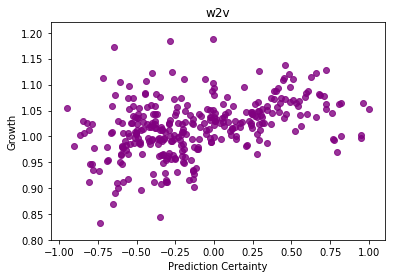

In [559]:
df_metrics_w2v['y_true'] = y_test_w2v
data_for_model = df_metrics_w2v[['top_vs_mean_low', 'y_true']]
ax_sca_w2v = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_w2v.set_title('w2v') 
ax_sca_w2v.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_w2v

[<matplotlib.text.Text at 0x1d51fc748>, <matplotlib.text.Text at 0x1d51f22b0>]

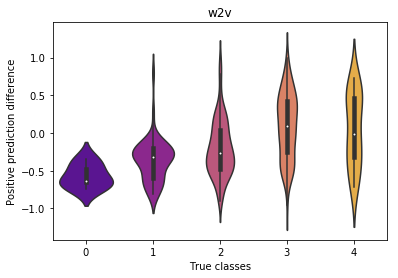

In [573]:
true_classes = y_cat_test_w2v.values.argmax(axis=1)
ax_w2v = sns.violinplot(x=true_classes, y=df_metrics_w2v['top_vs_mean_low'], palette="plasma") 
ax_w2v.set_title('w2v') 
ax_w2v.set(xlabel='True classes', ylabel='Positive prediction difference')

[<matplotlib.text.Text at 0x1d3607f28>, <matplotlib.text.Text at 0x1d37e2a58>]

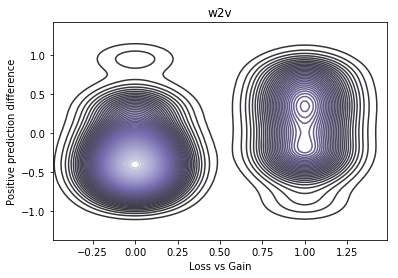

In [613]:
ax_w2v_kde = sns.kdeplot(df_metrics_w2v['gain_true'], df_metrics_w2v['top_vs_mean_low'], n_levels=90, cmap="Purples_d")
ax_w2v_kde.set_title('w2v')
ax_w2v_kde.set(xlabel='Loss vs Gain', ylabel='Positive prediction difference')

In [574]:
w_b = df_175_w_b.mean()

In [599]:
w_b = pd.DataFrame(w_b)

In [600]:
w_b.columns=['business']

In [601]:
w_b

,business
pred_count,124.400000
gain_10%,0.118432
gain_3%,0.694502
gain_mean,0.946651
top_pred_prob_10%,0.228000
top_pred_prob_3%,0.876000
top_pred_prob_mean,0.972000
model_pred_prob_10%,0.091802
model_pred_prob_3%,0.536223
model_pred_prob_mean,0.900136


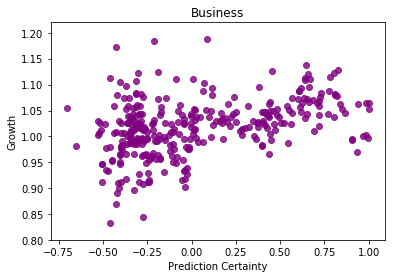

In [563]:
df_metrics_b['y_true'] = y_test_business
data_for_model = df_metrics_b[['top_vs_mean_low', 'y_true']]
ax_sca_b = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_b.set_title('Business') 
ax_sca_b.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_b

[<matplotlib.text.Text at 0x1d465d748>, <matplotlib.text.Text at 0x1d4669898>]

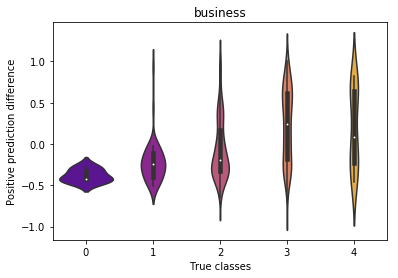

In [570]:
true_classes = y_cat_test.values.argmax(axis=1)
ax_business = sns.violinplot(x=true_classes, y=df_metrics_b['top_vs_mean_low'], palette="plasma")
ax_business.set_title('business')
ax_business.set(xlabel='True classes', ylabel='Positive prediction difference')

[<matplotlib.text.Text at 0x1d5555f60>, <matplotlib.text.Text at 0x1d66570b8>]

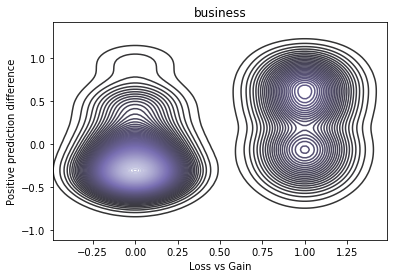

In [612]:
ax_business_kde = sns.kdeplot(df_metrics_b['gain_true'], df_metrics_b['top_vs_mean_low'], n_levels=90, cmap="Purples_d")
ax_business_kde.set_title('business')
ax_business_kde.set(xlabel='Loss vs Gain', ylabel='Positive prediction difference')

In [602]:
w_z = df_175_w_z.mean()
w_z = pd.DataFrame(w_z)
w_z.columns=['Zillow']
w_z

,Zillow
pred_count,126.800000
gain_10%,0.133799
gain_3%,0.709302
gain_mean,0.951756
top_pred_prob_10%,0.228000
top_pred_prob_3%,0.796000
top_pred_prob_mean,0.940000
model_pred_prob_10%,0.087084
model_pred_prob_3%,0.491733
model_pred_prob_mean,0.874210


In [603]:
metrics_merge_1 = pd.merge(w_z, w_b, right_index=True, left_index=True, how='inner')

In [604]:
metrics_merge_1

,Zillow,business
pred_count,126.800000,124.400000
gain_10%,0.133799,0.118432
gain_3%,0.709302,0.694502
gain_mean,0.951756,0.946651
top_pred_prob_10%,0.228000,0.228000
top_pred_prob_3%,0.796000,0.876000
top_pred_prob_mean,0.940000,0.972000
model_pred_prob_10%,0.087084,0.091802
model_pred_prob_3%,0.491733,0.536223
model_pred_prob_mean,0.874210,0.900136


In [605]:
metrics_merge_2 = pd.merge(metrics_merge_1, w_, right_index=True, left_index=True, how='inner')

In [606]:
metrics_merge_2

,Zillow,business,w2v
pred_count,126.800000,124.400000,99.000000
gain_10%,0.133799,0.118432,0.142971
gain_3%,0.709302,0.694502,0.702255
gain_mean,0.951756,0.946651,0.945688
top_pred_prob_10%,0.228000,0.228000,0.232000
top_pred_prob_3%,0.796000,0.876000,0.804000
top_pred_prob_mean,0.940000,0.972000,0.960000
model_pred_prob_10%,0.087084,0.091802,0.085449
model_pred_prob_3%,0.491733,0.536223,0.497578
model_pred_prob_mean,0.874210,0.900136,0.868175


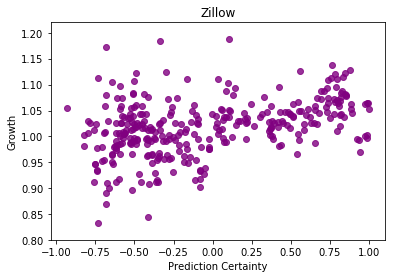

In [567]:
df_metrics_z['y_true'] = y_test
data_for_model = df_metrics_z[['top_vs_mean_low', 'y_true']]
ax_sca_z = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_z.set_title('Zillow') 
ax_sca_z.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_z

[<matplotlib.text.Text at 0x1d3601a20>, <matplotlib.text.Text at 0x1d31973c8>]

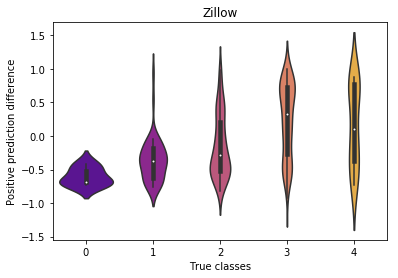

In [568]:
true_classes = y_cat_test.values.argmax(axis=1)
ax_zillow = sns.violinplot(x=true_classes, y=df_metrics_z['top_vs_mean_low'], palette="plasma")
ax_zillow.set_title('Zillow')
ax_zillow.set(xlabel='True classes', ylabel='Positive prediction difference')

[<matplotlib.text.Text at 0x1d37ee240>, <matplotlib.text.Text at 0x1d6dfb080>]

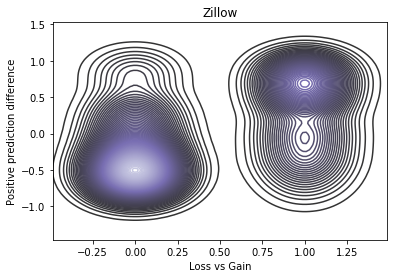

In [614]:
ax_zillow_kde = sns.kdeplot(df_metrics_z['gain_true'], df_metrics_z['top_vs_mean_low'], n_levels=90, cmap="Purples_d")
ax_zillow_kde.set_title('Zillow')
ax_zillow_kde.set(xlabel='Loss vs Gain', ylabel='Positive prediction difference')

In [293]:
business_features_2 = pd.read_csv('real_business_features_3_4')

[(0, 150)]

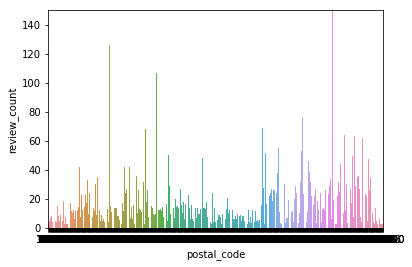

In [353]:
ax_tot = sns.barplot(business_features_2['postal_code'], business_features_2['review_count'])
ax_tot.set(ylim=(0, 150))